Reading data from Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx, sheet=Commodity_Production…
Creating combined figure with both mining types…
Creating sequential plot with 12 items in requested order
Saved: Visualizations/Land Use\commodity_boxplots_combined_log_all_mining_types.png


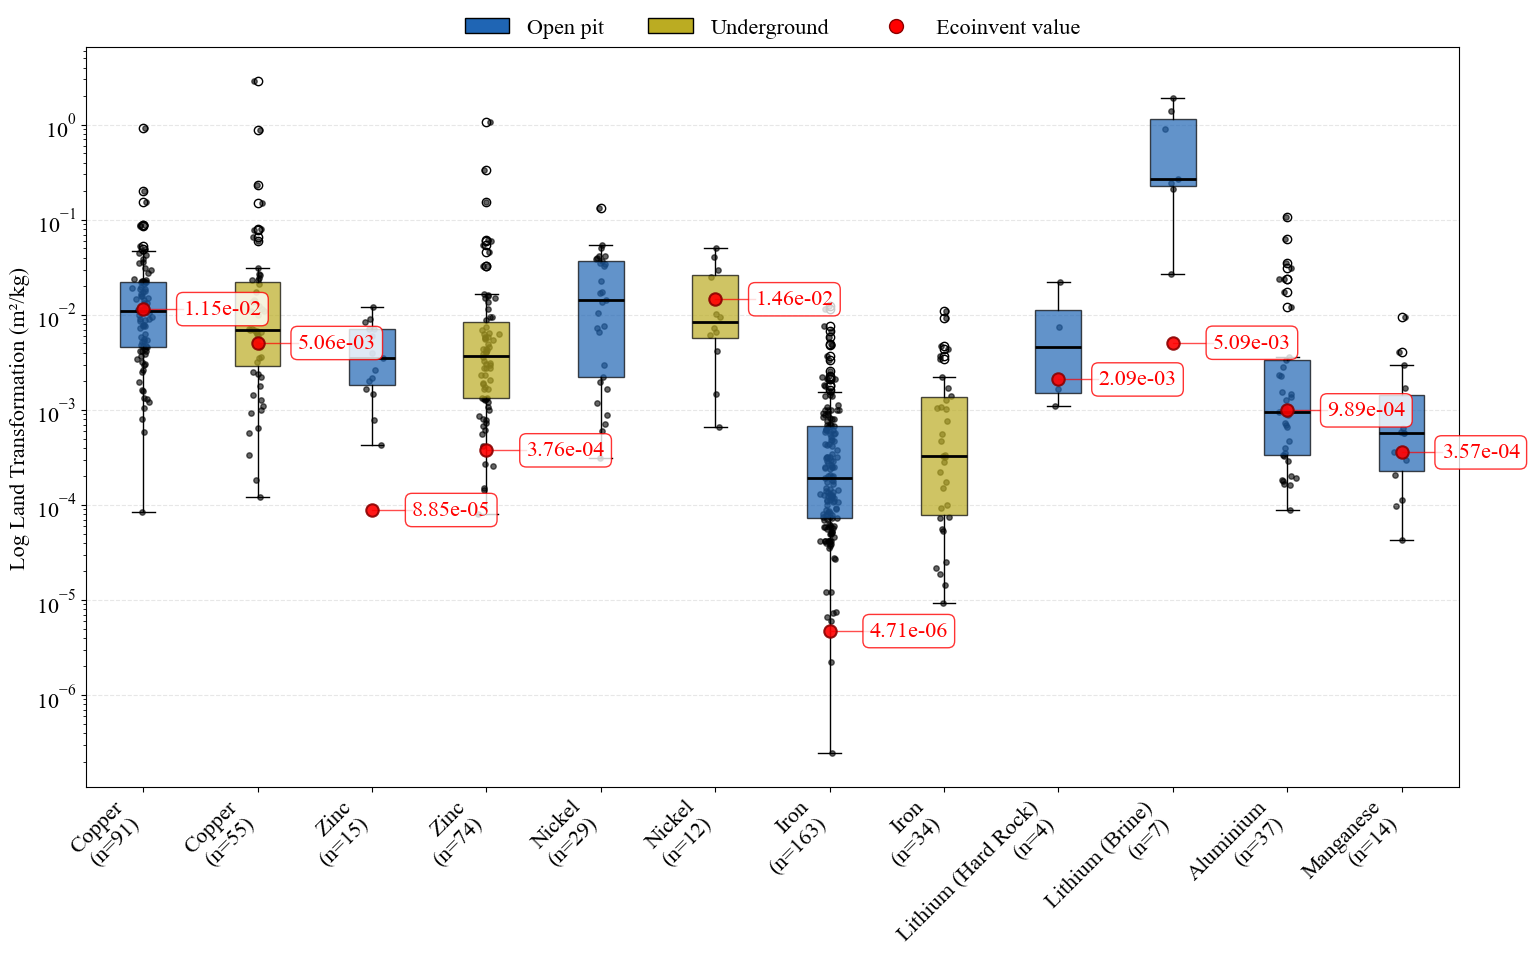

Combined plot: OK


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# --- Configuration -----------------------------------------------------------
# Ecoinvent values (m²/kg)
selected_commodities_open_pit = {
    'Aluminium': 0.000989464,
    'Copper': 0.0115,
    'Iron': 0.00000471188,
    'Lithium (Hard Rock)': 0.00209185,
    'Lithium (Brine)': 0.005089552,
    'Manganese': 0.000357402,
    'Zinc': 0.0000885337,
    'Nickel': 0,
}

selected_commodities_underground = {
    'Copper': 0.00506,
    'Nickel': 0.0146,
    'Zinc': 0.000375773,
    'Iron': 0,
}

OUTPUT_DIR = "Visualizations/Land Use"
INPUT_PATH = "Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx"
#INPUT_PATH = "Data Output/Commodity Production/mine_type_test.xlsx"
INPUT_SHEET = "Commodity_Production"
REQUIRED_COLUMNS = ['PRIMARY_COMMODITY', 'Prim_area (m2)', 'CumProd_Tonnes', 'MINE_TYPE1']

# ---- Figure-wide typography controls ---------------------------------------
FIG_FONT_FAMILY = "Times New Roman"     # e.g., "Arial", "Calibri", "DejaVu Sans"
FIG_FONT_SIZE   = 16          # one size for labels, ticks, legend, annotations
FIG_BOLD        = False        # <-- toggle this: True for bold, False for normal

def configure_matplotlib_fonts(family: str, size: int, bold: bool):
    """Apply family, size, and global weight across the entire figure."""
    weight = 'bold' if bold else 'normal'
    mpl.rcParams.update({
        'font.family': family,
        'font.size': size,
        'font.weight': weight,
        'axes.labelweight': weight,
        'axes.titleweight': weight,
        'axes.labelsize': size,
        'xtick.labelsize': size,
        'ytick.labelsize': size,
        'legend.fontsize': size,
    })
    return weight

# --- Helpers -----------------------------------------------------------------

def ensure_output_dir():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

def apply_lithium_grouping(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['MODIFIED_PRIMARY_COMMODITY'] = out['PRIMARY_COMMODITY'].astype(str)
    lithium_mask = out['PRIMARY_COMMODITY'].str.contains('Lithium', case=False, na=False)
    open_pit_lithium_mask = lithium_mask & (out['MINE_TYPE1'] == 'Open Pit')
    brine_mask = out['MINE_TYPE1'] == 'Brine'
    out.loc[open_pit_lithium_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Hard Rock)'
    out.loc[brine_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Brine)'
    return out

def normalize_names(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    name_map = {
        'Bauxite': 'Aluminium',
        'Iron Ore': 'Iron',
        'aluminium': 'Aluminium',
        'iron ore': 'Iron',
    }
    out['MODIFIED_PRIMARY_COMMODITY'] = out['MODIFIED_PRIMARY_COMMODITY'].replace(name_map)
    return out

def _prep(x: pd.DataFrame) -> pd.DataFrame:
    x = x.dropna(subset=['MODIFIED_PRIMARY_COMMODITY', 'Prim_area (m2)', 'CumProd_Tonnes']).copy()
    x['Prim_area (m2)'] = pd.to_numeric(x['Prim_area (m2)'], errors='coerce')
    x['CumProd_Tonnes'] = pd.to_numeric(x['CumProd_Tonnes'], errors='coerce')
    if 'm2/kg' not in x.columns:
        x['m2/kg'] = x['Prim_area (m2)'] / (x['CumProd_Tonnes'] * 1000.0)
    x['m2/kg'] = pd.to_numeric(x['m2/kg'], errors='coerce')
    x = x.dropna(subset=['Prim_area (m2)', 'CumProd_Tonnes', 'm2/kg'])
    x = x[x['m2/kg'] > 0]
    return x

# --- Combined Figure (sequential with specific order) ------------------------

def create_combined_figure(df: pd.DataFrame, font_weight: str) -> bool:
    print("Creating combined figure with both mining types…")

    # Use the same blue as in your seaborn-based script (matplotlib C0 / seaborn deep blue)
    OPEN_PIT_BLUE = "#1f65b4"  # same as 'tab:blue' / default seaborn blue
    UNDERGROUND_RED = "#bbac22"

    allowed = set(selected_commodities_open_pit.keys()) | set(selected_commodities_underground.keys())

    order_pairs = [
        ('Copper', 'open_pit'), ('Copper', 'underground'),
        ('Zinc', 'open_pit'), ('Zinc', 'underground'),
        ('Nickel', 'open_pit'), ('Nickel', 'underground'),
        ('Iron', 'open_pit'), ('Iron', 'underground'),
        ('Lithium (Hard Rock)', 'open_pit'), ('Lithium (Hard Rock)', 'underground'),
        ('Lithium (Brine)', 'open_pit'), ('Lithium (Brine)', 'underground'),
        ('Aluminium', 'open_pit'),
        ('Manganese', 'open_pit'),
    ]

    open_brine_df = df[df['MINE_TYPE1'].isin(['Open Pit', 'Brine'])].copy()
    open_brine_df = apply_lithium_grouping(open_brine_df)
    open_brine_df = normalize_names(open_brine_df)
    open_brine_df = _prep(open_brine_df)

    underground_df = df[df['MINE_TYPE1'] == 'Underground'].copy()
    underground_df['MODIFIED_PRIMARY_COMMODITY'] = underground_df['PRIMARY_COMMODITY'].astype(str)
    underground_df = normalize_names(underground_df)
    underground_df = _prep(underground_df)

    def get_data(commodity: str, mtype: str):
        if commodity not in allowed:
            return np.array([])
        if mtype == 'open_pit':
            return open_brine_df.loc[open_brine_df['MODIFIED_PRIMARY_COMMODITY'] == commodity, 'm2/kg'].values
        else:
            return underground_df.loc[underground_df['MODIFIED_PRIMARY_COMMODITY'] == commodity, 'm2/kg'].values

    def get_ecoinvent(commodity: str, mtype: str) -> float:
        if mtype == 'open_pit':
            return float(selected_commodities_open_pit.get(commodity, 0))
        else:
            return float(selected_commodities_underground.get(commodity, 0))

    plot_items = []
    for commodity, mtype in order_pairs:
        vals = get_data(commodity, mtype)
        if vals.size > 0:
            plot_items.append((commodity, mtype, vals, get_ecoinvent(commodity, mtype)))

    if not plot_items:
        print("No valid data found for combined analysis")
        return False

    print(f"Creating sequential plot with {len(plot_items)} items in requested order")

    fig, ax = plt.subplots(figsize=(max(15, len(plot_items) * 1.3), 10))

    positions, labels = [], []
    pos_counter = 1

    for commodity, mtype, vals, eco in plot_items:
        # COLORS: seaborn default blue for open pit; red for underground
        face = OPEN_PIT_BLUE if mtype == 'open_pit' else UNDERGROUND_RED

        ax.boxplot([vals], positions=[pos_counter], patch_artist=True,
                   boxprops=dict(facecolor=face, alpha=0.7, edgecolor='black'),
                   medianprops=dict(color='black', linewidth=2), widths=0.4)
        xj = np.random.normal(pos_counter, 0.03, size=vals.size)
        ax.scatter(xj, vals, alpha=0.6, color='black', s=15)

        if eco > 0:
            ax.scatter(pos_counter, eco, color='red', s=80, zorder=5,
                       marker='o', edgecolors='darkred', linewidth=1.5, alpha=0.9, label='_nolegend_')
            ax.plot([pos_counter, pos_counter + 0.35], [eco, eco], color='red', linewidth=1, alpha=0.7)
            ax.text(pos_counter + 0.35, eco, f'{eco:.2e}', va='center',
                    fontsize=FIG_FONT_SIZE, color='red', fontweight=font_weight,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))

        positions.append(pos_counter)
        labels.append(f"{commodity}\n(n={vals.size})")
        pos_counter += 1

    ax.set_yscale('log')
    ax.set_ylabel('Log Land Transformation (m²/kg)', fontweight=font_weight)
    ax.set_xlabel('')  # remove x-axis title
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=FIG_FONT_SIZE, fontweight=font_weight, ha='center')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    from matplotlib.patches import Patch
    handles = [
        Patch(facecolor=OPEN_PIT_BLUE, edgecolor='black', label='Open pit'),
        Patch(facecolor=UNDERGROUND_RED, edgecolor='black', label='Underground'),
        plt.Line2D([0], [0], marker='o', color='w', label='Ecoinvent value',
                   markerfacecolor='red', markeredgecolor='darkred', markersize=10)
    ]

    # Legend snug against the top edge, single line
    ax.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),   # bottom of legend touches top of axes
        ncol=len(handles),
        frameon=False,
        borderaxespad=0.0,
        prop={'weight': font_weight, 'size': FIG_FONT_SIZE}
    )

    plt.tight_layout()

    ensure_output_dir()
    png_out = os.path.join(OUTPUT_DIR, 'commodity_boxplots_combined_log_all_mining_types.png')
    #png_out = os.path.join(OUTPUT_DIR, 'commodity_boxplots_combined_log_all_mining_types_mine_type_test.png')
    plt.savefig(png_out, dpi=600, bbox_inches='tight')
    print(f'Saved: {png_out}')
    plt.show()
    return True

# --- Main --------------------------------------------------------------------
if __name__ == '__main__':
    FONT_WEIGHT = configure_matplotlib_fonts(FIG_FONT_FAMILY, FIG_FONT_SIZE, FIG_BOLD)
    print(f"Reading data from {INPUT_PATH}, sheet={INPUT_SHEET}…")
    try:
        df = pd.read_excel(INPUT_PATH, sheet_name=INPUT_SHEET)
    except Exception as e:
        raise SystemExit(f"Error loading sheet '{INPUT_SHEET}': {e}")

    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise SystemExit(f"Missing required columns: {missing}")

    ok = create_combined_figure(df, FONT_WEIGHT)
    print("Combined plot:", "OK" if ok else "No data/failed")





In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math
import matplotlib as mpl
from matplotlib.lines import Line2D


def create_dual_commodity_box_plots(
    input_file,
    output_folder,
    # Typography controls (single size everywhere)
    font_family: str = "Times New Roman",
    font_size: int = 18,
    font_style: str = "normal",  # "normal", "italic", or "oblique"
    bold: bool = False,
):
    """
    Creates log-scale images with subplots for each commodity showing land use values
    with ecoinvent reference lines.

    Open Pit/Brine: up to 2 figures (first 4 panels, then next 4) — LOG SCALE ONLY.
    Underground: 1 figure (up to 4 panels) — LOG SCALE ONLY.

    Typography (global, uniform size).

    UPDATE (2025-09-09):
    - Lithium is now split into **Lithium (Hard Rock)** and **Lithium (Brine)**, each as its own subplot.
    - In Open Pit & Brine layouts, **Lithium (Brine)** is forced to appear at the **top-left of part 2**.
    - Open Pit part 2 now shows **four** subplots; Nickel is included when data meets thresholds.
    """

    # ---------------- Typography setup (uniform size) ----------------
    weight = "bold" if bold else "normal"
    mpl.rcParams.update({
        "font.family": font_family,
        "font.size": font_size,
        "font.style": font_style,
        "font.weight": weight,
        "axes.titlesize": font_size,
        "axes.titleweight": weight,
        "axes.labelsize": font_size,
        "axes.labelweight": weight,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
    })

    # Define specific commodities to include and their global ecoinvent values (m²/kg)
    selected_commodities_open_pit = {
        'Aluminium': 0.000989464,
        'Copper': 0.0115,
        'Iron': 0.00000471188,
        'Lithium (Hard Rock)': 0.00209185,
        'Lithium (Brine)': 0.005089552,
        'Manganese': 0.000357402,
        'Zinc': 0.0000885337,
        'Nickel': 0,
    }

    selected_commodities_underground = {
        'Copper': 0.00506,
        'Nickel': 0.0146,
        'Zinc': 0.000375773,
        'Iron': 0,
    }

    # Country-specific ecoinvent values (m²/kg)
    country_specific_ecoinvent_open_pit = {
        'Copper': {
            'Australia': 0.01161662, 'Kazakhstan': 0.0040986, 'Zambia': 0.0042483,
            'Russia': 0.0060475, 'China': 0.0039481, 'USA': 0.0107145,
            'Indonesia': 0.0066133, 'Chile': 0.0073083, 'Canada': 0.0142734
        },
        'Iron': { 'Canada': 0.00013718, 'India': 0.000059809 },
        # Lithium country-specific value applies to **Hard Rock** mines
        'Lithium (Hard Rock)': { 'Australia': 0.0020917 }
        # 'Lithium (Brine)': {}  # (none specified)
    }

    country_specific_ecoinvent_underground = {
        'Copper': {
            'Australia': 0.00498, 'Kazakhstan': 0.00176, 'Zambia': 0.00182,
            'Russia': 0.00259, 'China': 0.00169, 'USA': 0.00459,
            'Indonesia': 0.00283, 'Chile': 0.00313, 'Canada': 0.00612
        },
        'Nickel': { 'Canada': 0.00626, 'China': 0.01459 },
    }

    # Load the Excel file
    print(f"Loading data from {input_file}...")
    df = pd.read_excel(input_file, sheet_name='Commodity_Production')

    # Check required columns
    if 'MINE_TYPE1' not in df.columns:
        raise ValueError("Required column 'MINE_TYPE1' not found")
    print(f"Total mines in dataset: {len(df)}")

    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Process Open Pit/Brine mines (LOG ONLY)
    print("\n" + "=" * 60)
    print("PROCESSING OPEN PIT AND BRINE MINES (log scale only)")
    print("=" * 60)
    success_open_pit = process_mining_type(
        df=df,
        selected_commodities=selected_commodities_open_pit,
        country_specific_ecoinvent=country_specific_ecoinvent_open_pit,
        mine_types=['Open Pit', 'Brine'],
        output_folder=output_folder,
        output_suffix='open-pit-brine',
        mining_type_name='Open Pit and Brine',
        font_size=font_size
    )

    # Process Underground mines (LOG ONLY)
    print("\n" + "=" * 60)
    print("PROCESSING UNDERGROUND MINES (log scale only)")
    print("=" * 60)
    success_underground = process_mining_type(
        df=df,
        selected_commodities=selected_commodities_underground,
        country_specific_ecoinvent=country_specific_ecoinvent_underground,
        mine_types=['Underground'],
        output_folder=output_folder,
        output_suffix='underground',
        mining_type_name='Underground',
        font_size=font_size
    )

    # Summary
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE")
    print("=" * 60)
    if success_open_pit:
        print("✓ Open Pit and Brine analysis completed successfully!")
    else:
        print("✗ Open Pit and Brine analysis failed or had no data")

    if success_underground:
        print("✓ Underground analysis completed successfully!")
    else:
        print("✗ Underground analysis failed or had no data")

    return success_open_pit or success_underground


def process_mining_type(df,
                        selected_commodities,
                        country_specific_ecoinvent,
                        mine_types,
                        output_folder,
                        output_suffix,
                        mining_type_name,
                        font_size: int):
    """Process a specific mining type and create LOG-SCALE plots only."""

    # Uniform sizes
    title_size = label_size = tick_size = legend_size = font_size

    # Filter for specified mine types
    filtered_df = df[df['MINE_TYPE1'].isin(mine_types)].copy()
    print(f"Total {mining_type_name} mines after filtering: {len(filtered_df)}")
    if filtered_df.empty:
        print(f"No {mining_type_name} mines found in the dataset")
        return False

    # Create a new column for the modified primary commodity
    filtered_df['MODIFIED_PRIMARY_COMMODITY'] = filtered_df['PRIMARY_COMMODITY'].copy()

    # ---- NEW: Split Lithium into Hard Rock vs Brine ----
    lithium_mask = filtered_df['PRIMARY_COMMODITY'].str.contains('Lithium', case=False, na=False)
    brine_mask = (filtered_df['MINE_TYPE1'] == 'Brine')
    hard_rock_mask = lithium_mask & ~brine_mask

    # Assign split labels
    filtered_df.loc[hard_rock_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Hard Rock)'
    filtered_df.loc[brine_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Brine)'

    # Normalize commodity names to match selected_commodities keys
    commodity_name_map = { 'Bauxite': 'Aluminium', 'Iron Ore': 'Iron' }
    filtered_df['MODIFIED_PRIMARY_COMMODITY'] = filtered_df['MODIFIED_PRIMARY_COMMODITY'].replace(commodity_name_map)

    # Compute m2/kg if needed
    if 'm2/kg' not in filtered_df.columns:
        print("Calculating m2/kg column...")
        if 'Prim_area (m2)' not in filtered_df.columns or 'CumProd_Tonnes' not in filtered_df.columns:
            raise ValueError("Required columns 'Prim_area (m2)' or 'CumProd_Tonnes' not found")
        filtered_df['m2/kg'] = filtered_df['Prim_area (m2)'] / (filtered_df['CumProd_Tonnes'] * 1000)
        print("m2/kg column calculated")

    # Ensure country column
    if 'COUNTRY_NAME' not in filtered_df.columns:
        if 'COUNTRY' in filtered_df.columns:
            filtered_df['COUNTRY_NAME'] = filtered_df['COUNTRY']
        else:
            raise ValueError("Neither 'COUNTRY_NAME' nor 'COUNTRY' column found")

    # Process each commodity
    valid_commodities = []
    commodity_data = {}

    for commodity_key, global_ecoinvent_value in selected_commodities.items():
        canonical = commodity_key  # <— keep each commodity distinct (incl. Lithium split)
        commodity_df = filtered_df[filtered_df['MODIFIED_PRIMARY_COMMODITY'] == canonical]

        if commodity_df.empty:
            print(f"No data found for {canonical}")
            continue

        # Countries with thresholded minimum number of mines
        country_counts = commodity_df.groupby('COUNTRY_NAME').size()

        # ---- RULE: In Open Pit & Brine, Copper and Iron need ≥ 3; otherwise ≥ 2 ----
        threshold = 3 if (mining_type_name == 'Open Pit and Brine' and canonical in ['Copper', 'Iron']) else 2

        valid_countries = country_counts[country_counts >= threshold].index.tolist()
        if len(valid_countries) == 0:
            print(f"Skipping {canonical} - not enough countries with ≥{threshold} mines")
            continue

        # Filter plot data and remove non-positive values
        plot_df = commodity_df[commodity_df['COUNTRY_NAME'].isin(valid_countries)]
        plot_df = plot_df[plot_df['m2/kg'] > 0]
        if plot_df.empty:
            print(f"No valid data for {canonical} after filtering")
            continue

        # Initialize/store once per canonical commodity
        valid_commodities.append(canonical)
        commodity_data[canonical] = {
            'data': plot_df,
            'countries': valid_countries,
            'sample_sizes': country_counts[valid_countries].to_dict(),
            'global_ecoinvent_value': global_ecoinvent_value if (global_ecoinvent_value and global_ecoinvent_value > 0) else None,
            'country_specific_ecoinvent': country_specific_ecoinvent.get(canonical, {})
        }

    if not valid_commodities:
        print(f"No valid data found for any commodity in {mining_type_name} mines")
        return False

    # ---- Custom layouts & multiple figures (LOG ONLY) ----
    if mining_type_name == 'Open Pit and Brine':
        # Preferred plotting order so that the single figure is deterministic.
        # With 2 columns, indices are row-major:
        #   Row1: 0,1 | Row2: 2,3 | Row3: 4,5 | Row4: 6,7
        # Keeping Lithium (Brine) as the 5th item (index 4) puts it at top-left of row 3.
        preferred_order = [
            'Aluminium', 'Copper', 'Iron', 'Lithium (Hard Rock)',
            'Lithium (Brine)', 'Manganese', 'Zinc', 'Nickel'
        ]
        # Keep only valid commodities, preserving the preferred order
        ordered_valid = [c for c in preferred_order if c in valid_commodities]

        if not ordered_valid:
            print(f"No valid subsets for {mining_type_name}.")
            return False

        # Single figure: 2 columns, legend shown, two-line tick labels,
        # and figure label (A) for Open Pit & Brine.
        create_and_save_plots(
            ordered_valid,
            commodity_data,
            output_folder,
            output_suffix,                  # will be 'open-pit-brine'
            mining_type_name,
            log_scale=True,
            n_cols=2,
            show_legend=True,               # legend visible in this single figure
            add_top_right_xlabel=False,     # (placeholder flag, not used)
            single_line_xticklabels=False,  # two-line tick labels with (n=)
            align_bottom_xlabel=False,      # standard axis labels
            font_size=font_size,
            figure_label="(A)"              # label Open Pit & Brine as (A)
        )

        print(f"All {mining_type_name} commodity box plots created and saved (single log-scale figure).")
        return True


    elif mining_type_name == 'Underground':
        # Underground: single-line tick labels, and align BOTH bottom x-axis 'Country' labels to the same line
        create_and_save_plots(
            valid_commodities, commodity_data, output_folder,
            output_suffix, mining_type_name, log_scale=True, n_cols=2,
            show_legend=True,
            add_top_right_xlabel=False,
            single_line_xticklabels=True,       # keep single-line tick labels
            align_bottom_xlabel=True,           # put both bottom xlabels on the same line
            font_size=font_size,
            series_color="#bbac22",             # Underground: color ONLY the box plots
            figure_label="(B)"                  # label Underground figure as (B)
        )
        print(f"All {mining_type_name} commodity box plots created and saved (single log-scale figure).")
        return True

    # Fallback
    create_and_save_plots(
        valid_commodities, commodity_data, output_folder, output_suffix,
        mining_type_name, log_scale=True,
        show_legend=True, add_top_right_xlabel=False,
        single_line_xticklabels=False, align_bottom_xlabel=False, font_size=font_size
    )
    return True


def create_and_save_plots(valid_commodities,
                          commodity_data,
                          output_folder,
                          output_suffix,
                          mining_type_name,
                          log_scale=True,
                          n_cols=None,
                          show_legend: bool = True,
                          add_top_right_xlabel: bool = False,
                          single_line_xticklabels: bool = False,
                          align_bottom_xlabel: bool = False,
                          font_size: int = 10,
                          series_color=None,
                          figure_label=None):
    """
    Creates and saves the commodity box plots with logarithmic y-axis.
    Figure-level legend is optional.
    X-axis:
      - Tick labels on ALL subplots.
      - No 'Country' axis label anywhere (removed globally).

    UPDATED:
      - Lithium special casing removed; each commodity has at most one global ecoinvent line.
    """
    # Uniform sizes
    title_size = label_size = tick_size = legend_size = font_size

    if not log_scale:
        log_scale = True

    print(f"Creating logarithmic scale plots for {len(valid_commodities)} commodities...")

    # Grid layout
    n_plots = len(valid_commodities)
    if n_cols is None:
        n_cols = min(3, n_plots)
    n_rows = max(1, math.ceil(n_plots / n_cols))

    # Figure
    fig_width = 8 * n_cols
    fig_height = 6 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Track which legend items appear across subplots
    used_country_specific = False
    used_global_any = False

    # Create subplots
    for i, commodity in enumerate(valid_commodities):
        ax = axes[i]
        plot_df = commodity_data[commodity]['data']
        global_ecoinvent_value = commodity_data[commodity]['global_ecoinvent_value']
        country_specific_values = commodity_data[commodity]['country_specific_ecoinvent']

        # Box plot: color only if series_color is provided (Underground case)
        boxplot_kwargs = dict(width=0.6, fliersize=3, showfliers=True, ax=ax)
        if series_color is not None:
            boxplot_kwargs.update({
                "boxprops": {"facecolor": series_color, "edgecolor": "black"},
                "medianprops": {"color": "black"},
                "whiskerprops": {"color": "black"},
                "capprops": {"color": "black"},
            })
        sns.boxplot(x='COUNTRY_NAME', y='m2/kg', data=plot_df, **boxplot_kwargs)

        # Swarm plot stays black regardless of series_color
        sns.swarmplot(x='COUNTRY_NAME', y='m2/kg', data=plot_df,
                      color="black", alpha=0.7, size=4, ax=ax)

        # Log scale
        ax.set_yscale('log')

        # ---- Country-specific ecoinvent dots ----
        countries_in_plot = plot_df['COUNTRY_NAME'].unique()
        any_country_dot = False
        for j, country in enumerate(countries_in_plot):
            if country in country_specific_values:
                country_ecoinvent = country_specific_values[country]
                ax.scatter(
                    j, country_ecoinvent,
                    color='red', s=20, zorder=5, marker='o',
                    edgecolors='darkred', linewidth=2, alpha=0.9
                )
                any_country_dot = True
        if any_country_dot:
            used_country_specific = True

        # ---- Global ecoinvent line (if available) ----
        if global_ecoinvent_value is not None:
            ax.axhline(y=global_ecoinvent_value, color='red', linestyle='--', linewidth=2)
            used_global_any = True

        # Titles/labels (uniform sizes)
        ax.set_title(f'{commodity}', fontsize=title_size)

        # y-axis title only on left column subplots
        if (i % n_cols) == 0:
            ax.set_ylabel('Log Land Transformation (m²/kg)', fontsize=label_size)
        else:
            ax.set_ylabel('')

        # ---- X-axis tick labels on ALL subplots ----
        if len(commodity_data[commodity]['countries']) > 3:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)

        # Build labels (two-line or one-line depending on flag)
        current_labels = [item.get_text() for item in ax.get_xticklabels()]
        if not any(current_labels):
            current_labels = list(plot_df['COUNTRY_NAME'].unique())

        if single_line_xticklabels:
            new_labels = [
                f"{country} (n={commodity_data[commodity]['sample_sizes'].get(country, '')})"
                for country in current_labels
            ]
        else:
            new_labels = [
                f"{country}\n(n={commodity_data[commodity]['sample_sizes'].get(country, '')})"
                for country in current_labels
            ]
        ax.set_xticklabels(new_labels, fontsize=tick_size)

        # Remove x-axis label text globally
        ax.set_xlabel('')

        # Gridlines
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for j in range(len(valid_commodities), len(axes)):
        axes[j].set_visible(False)

    # ---- Layout & optional legend ----
    top_rect = 0.93 if show_legend else 1.0
    bottom_rect = 0.0
    plt.tight_layout(rect=(0, bottom_rect, 1, top_rect))

    legend_anchor_y = 0.94

    if show_legend:
        handles = []
        labels = []
        if used_country_specific:
            handles.append(Line2D([], [], marker='o', linestyle='None',
                                  color='red', markerfacecolor='red',
                                  markeredgecolor='darkred', markersize=6))
            labels.append('Country-specific ecoinvent')
        if used_global_any:
            handles.append(Line2D([], [], linestyle='--', color='red', linewidth=2))
            labels.append('Global ecoinvent')

        if handles:
            fig.legend(
                handles=handles, labels=labels,
                loc='upper center', bbox_to_anchor=(0.5, legend_anchor_y),
                ncol=len(handles), frameon=False, fontsize=legend_size,
                handlelength=2.5, borderaxespad=0.15, labelspacing=0.15,
                columnspacing=0.8, handletextpad=0.35
            )

    if figure_label and show_legend:
        fig.text(0.01, legend_anchor_y, figure_label, ha='left', va='center',
                 fontsize=legend_size)

    base = f"all_commodity_boxplots_log_{output_suffix}_with_country_specific"
    #base = f"all_commodity_boxplots_log_{output_suffix}_with_country_specific_mine_type_test"
    png_path = os.path.join(output_folder, f"{base}.png")
    plt.savefig(png_path, dpi=800, bbox_inches='tight')
    print(f"Saved {mining_type_name} logarithmic scale plot to {png_path}")
    plt.close()

# Execute the function if run as a script
if __name__ == "__main__":
    try:
        create_dual_commodity_box_plots(
            input_file='Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx',
            #input_file='Data Output/Commodity Production/mine_type_test.xlsx',
            output_folder='Visualizations/Land Use',
            # Typography overrides example:
            # font_family="Times New Roman",
            # font_size=12,
            # font_style="italic",
            # bold=True,
        )
        print("Script completed successfully!")
    except Exception as e:
        print(f"Error: {e}")


Loading data from Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx...
Total mines in dataset: 606

PROCESSING OPEN PIT AND BRINE MINES (log scale only)
Total Open Pit and Brine mines after filtering: 360
Creating logarithmic scale plots for 8 commodities...


C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:420: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:437: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:420: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:437: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

Saved Open Pit and Brine logarithmic scale plot to Visualizations/Land Use\all_commodity_boxplots_log_open-pit-brine_with_country_specific.png
All Open Pit and Brine commodity box plots created and saved (single log-scale figure).

PROCESSING UNDERGROUND MINES (log scale only)
Total Underground mines after filtering: 178
Creating logarithmic scale plots for 4 commodities...


c:\Users\leshe\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:420: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:437: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\3055487643.py:437: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xt

Saved Underground logarithmic scale plot to Visualizations/Land Use\all_commodity_boxplots_log_underground_with_country_specific.png
All Underground commodity box plots created and saved (single log-scale figure).

PROCESSING COMPLETE
✓ Open Pit and Brine analysis completed successfully!
✓ Underground analysis completed successfully!
Script completed successfully!


Reading data from Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx, sheet=Commodity_Production…
Creating combined figure with both mining types…
Creating sequential plot with 12 items in requested order
Saved: Visualizations/Biogenic Carbon\commodity_boxplots_combined_log_all_mining_types.png


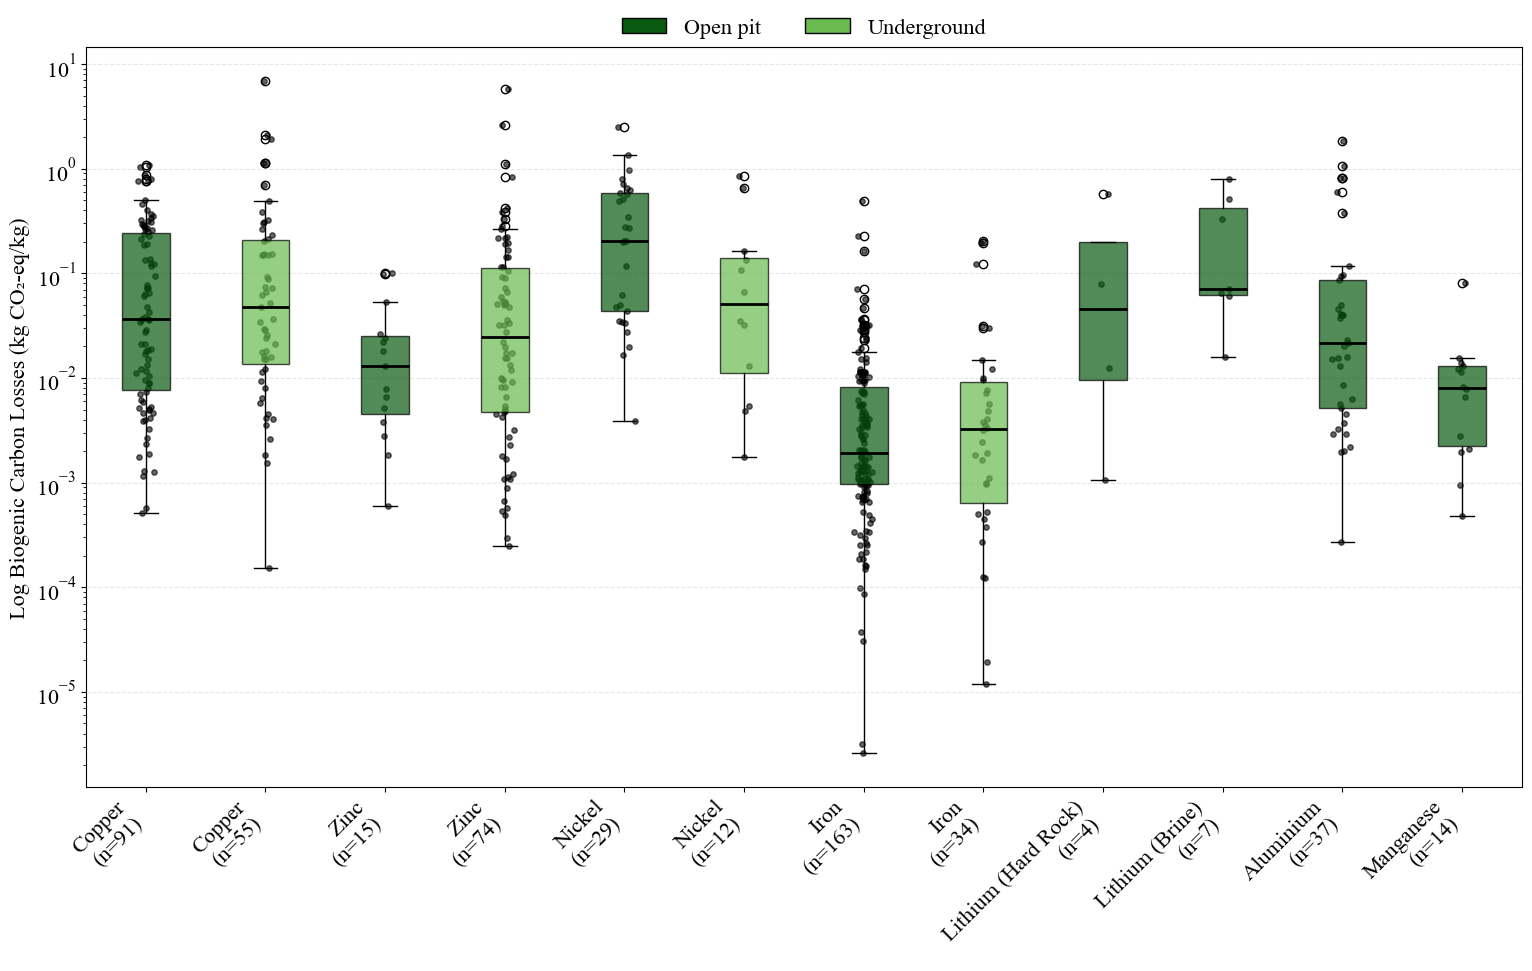

Combined plot: OK


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# --- Configuration -----------------------------------------------------------
OUTPUT_DIR = "Visualizations/Biogenic Carbon"  # save biogenic carbon plots here
INPUT_PATH = "Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx"
INPUT_SHEET = "Commodity_Production"

# Use this metric column instead of m2/kg
METRIC_COL = "Biomass Carbon (CO2eq/kg)"

REQUIRED_COLUMNS = ['PRIMARY_COMMODITY', METRIC_COL, 'MINE_TYPE1']

# ---- Figure-wide typography controls ---------------------------------------
FIG_FONT_FAMILY = "Times New Roman"
FIG_FONT_SIZE   = 16
FIG_BOLD        = False

def configure_matplotlib_fonts(family: str, size: int, bold: bool):
    """Apply family, size, and global weight across the entire figure."""
    weight = 'bold' if bold else 'normal'
    mpl.rcParams.update({
        'font.family': family,
        'font.size': size,
        'font.weight': weight,
        'axes.labelweight': weight,
        'axes.titleweight': weight,
        'axes.labelsize': size,
        'xtick.labelsize': size,
        'ytick.labelsize': size,
        'legend.fontsize': size,
    })
    return weight

# --- Helpers -----------------------------------------------------------------

def ensure_output_dir():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

def apply_lithium_grouping(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out['MODIFIED_PRIMARY_COMMODITY'] = out['PRIMARY_COMMODITY'].astype(str)
    lithium_mask = out['PRIMARY_COMMODITY'].str.contains('Lithium', case=False, na=False)
    open_pit_lithium_mask = lithium_mask & (out['MINE_TYPE1'] == 'Open Pit')
    brine_mask = out['MINE_TYPE1'] == 'Brine'
    out.loc[open_pit_lithium_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Hard Rock)'
    out.loc[brine_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Brine)'
    return out

def normalize_names(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    name_map = {
        'Bauxite': 'Aluminium',
        'Iron Ore': 'Iron',
        'aluminium': 'Aluminium',
        'iron ore': 'Iron',
    }
    out['MODIFIED_PRIMARY_COMMODITY'] = out['MODIFIED_PRIMARY_COMMODITY'].replace(name_map)
    return out

def _prep(x: pd.DataFrame) -> pd.DataFrame:
    # Keep only rows with the metric, ensure numeric, positive values
    x = x.dropna(subset=['MODIFIED_PRIMARY_COMMODITY', METRIC_COL]).copy()
    x[METRIC_COL] = pd.to_numeric(x[METRIC_COL], errors='coerce')
    x = x.dropna(subset=[METRIC_COL])
    x = x[x[METRIC_COL] > 0]
    return x

# --- Combined Figure (sequential with specific order) ------------------------

def create_combined_figure(df: pd.DataFrame, font_weight: str) -> bool:
    print("Creating combined figure with both mining types…")

    OPEN_PIT_BLUE = "#0a5a11ff"
    UNDERGROUND_RED = "#69bb50ff"

    order_pairs = [
        ('Copper', 'open_pit'), ('Copper', 'underground'),
        ('Zinc', 'open_pit'), ('Zinc', 'underground'),
        ('Nickel', 'open_pit'), ('Nickel', 'underground'),
        ('Iron', 'open_pit'), ('Iron', 'underground'),
        ('Lithium (Hard Rock)', 'open_pit'), 
        ('Lithium (Brine)', 'open_pit'), 
        ('Aluminium', 'open_pit'), 
        ('Manganese', 'open_pit'), 
    ]

    open_brine_df = df[df['MINE_TYPE1'].isin(['Open Pit', 'Brine'])].copy()
    open_brine_df = apply_lithium_grouping(open_brine_df)
    open_brine_df = normalize_names(open_brine_df)
    open_brine_df = _prep(open_brine_df)

    underground_df = df[df['MINE_TYPE1'] == 'Underground'].copy()
    underground_df['MODIFIED_PRIMARY_COMMODITY'] = underground_df['PRIMARY_COMMODITY'].astype(str)
    underground_df = normalize_names(underground_df)
    underground_df = _prep(underground_df)

    def get_data(commodity: str, mtype: str):
        if mtype == 'open_pit':
            return open_brine_df.loc[
                open_brine_df['MODIFIED_PRIMARY_COMMODITY'] == commodity, METRIC_COL
            ].values
        else:
            return underground_df.loc[
                underground_df['MODIFIED_PRIMARY_COMMODITY'] == commodity, METRIC_COL
            ].values

    plot_items = []
    for commodity, mtype in order_pairs:
        vals = get_data(commodity, mtype)
        if vals.size > 0:
            plot_items.append((commodity, mtype, vals))

    if not plot_items:
        print("No valid data found for combined analysis")
        return False

    print(f"Creating sequential plot with {len(plot_items)} items in requested order")

    fig, ax = plt.subplots(figsize=(max(15, len(plot_items) * 1.3), 10))

    positions, labels = [], []
    pos_counter = 1

    for commodity, mtype, vals in plot_items:
        face = OPEN_PIT_BLUE if mtype == 'open_pit' else UNDERGROUND_RED

        ax.boxplot([vals], positions=[pos_counter], patch_artist=True,
                   boxprops=dict(facecolor=face, alpha=0.7, edgecolor='black'),
                   medianprops=dict(color='black', linewidth=2), widths=0.4)
        # jittered points to show spread
        xj = np.random.normal(pos_counter, 0.03, size=vals.size)
        ax.scatter(xj, vals, alpha=0.6, color='black', s=15)

        positions.append(pos_counter)
        labels.append(f"{commodity}\n(n={vals.size})")
        pos_counter += 1

    ax.set_yscale('log')
    ax.set_ylabel('Log Biogenic Carbon Losses (kg CO₂-eq/kg)', fontweight=font_weight)
    ax.set_xlabel('')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=FIG_FONT_SIZE, fontweight=font_weight, ha='center')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    from matplotlib.patches import Patch
    handles = [
        Patch(facecolor=OPEN_PIT_BLUE, edgecolor='black', label='Open pit'),
        Patch(facecolor=UNDERGROUND_RED, edgecolor='black', label='Underground'),
    ]
    ax.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),
        ncol=len(handles),
        frameon=False,
        borderaxespad=0.0,
        prop={'weight': font_weight, 'size': FIG_FONT_SIZE}
    )

    plt.tight_layout()

    ensure_output_dir()
    png_out = os.path.join(OUTPUT_DIR, 'commodity_boxplots_combined_log_all_mining_types.png')
    plt.savefig(png_out, dpi=600, bbox_inches='tight')
    print(f'Saved: {png_out}')
    plt.show()
    return True

# --- Main --------------------------------------------------------------------
if __name__ == '__main__':
    FONT_WEIGHT = configure_matplotlib_fonts(FIG_FONT_FAMILY, FIG_FONT_SIZE, FIG_BOLD)
    print(f"Reading data from {INPUT_PATH}, sheet={INPUT_SHEET}…")
    try:
        df = pd.read_excel(INPUT_PATH, sheet_name=INPUT_SHEET)
    except Exception as e:
        raise SystemExit(f"Error loading sheet '{INPUT_SHEET}': {e}")

    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise SystemExit(f"Missing required columns: {missing}")

    ok = create_combined_figure(df, FONT_WEIGHT)
    print("Combined plot:", "OK" if ok else "No data/failed")



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math
import matplotlib as mpl
from matplotlib.lines import Line2D

# Column to use for Y-axis values
YCOL = "Biomass Carbon (CO2eq/kg)"


def create_dual_commodity_box_plots(
    input_file,
    output_folder,
    # Typography controls (single size everywhere)
    font_family: str = "Times New Roman",
    font_size: int = 18,
    font_style: str = "normal",  # "normal", "italic", or "oblique"
    bold: bool = False,
):
    """
    Creates log-scale images with subplots for each commodity showing **biogenic carbon** values,
    with ecoinvent reference overlays (global horizontal lines, optional country-specific dots).

    Open Pit/Brine: up to 2 figures (first 4 panels, then next 4) — LOG SCALE ONLY.
    Underground: 1 figure (up to 4 panels) — LOG SCALE ONLY.

    Lithium handling:
    - Lithium is split into **Lithium (Hard Rock)** and **Lithium (Brine)**, each as its own subplot.

    Ordering:
    - Subplots follow the insertion order of `selected_commodities_open_pit` and `selected_commodities_underground`.

    Typography (global, uniform size).
    """

    # ---------------- Typography setup (uniform size) ----------------
    weight = "bold" if bold else "normal"
    mpl.rcParams.update({
        "font.family": font_family,
        "font.size": font_size,
        "font.style": font_style,
        "font.weight": weight,
        "axes.titlesize": font_size,
        "axes.titleweight": weight,
        "axes.labelsize": font_size,
        "axes.labelweight": weight,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
    })

    # Define specific commodities to include.
    # Values are GLOBAL ecoinvent references for biogenic carbon (kg CO2-eq per kg metal) if available.
    selected_commodities_open_pit = {
        'Copper': 0.06659176,
        'Iron': 0.004097385,
        'Lithium (Hard Rock)': 0.053956977,
        'Lithium (Brine)': 0.126752313,
        'Manganese': 0.011800751,
        'Zinc': 0.031372434,
        'Aluminium': None,
        'Nickel': None,
    }

    selected_commodities_underground = {
        'Copper': 0.028539326,
        'Nickel': 9.917467429,
        'Zinc': 0.125489736,
        'Iron': None,
    }

    # Country-specific ecoinvent values (kg CO2-eq/kg) — add entries if you have them.
    country_specific_ecoinvent_open_pit = {}
    country_specific_ecoinvent_underground = {}

    # Load the Excel file
    print(f"Loading data from {input_file}...")
    df = pd.read_excel(input_file, sheet_name='Commodity_Production')

    # Check required columns
    required_cols = {'MINE_TYPE1', 'PRIMARY_COMMODITY', YCOL}
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Required column(s) missing: {missing}")
    print(f"Total mines in dataset: {len(df)}")

    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Process Open Pit/Brine mines (LOG ONLY)
    print("\n" + "=" * 60)
    print("PROCESSING OPEN PIT AND BRINE MINES (log scale only)")
    print("=" * 60)
    success_open_pit = process_mining_type(
        df=df,
        selected_commodities=selected_commodities_open_pit,
        country_specific_ecoinvent=country_specific_ecoinvent_open_pit,
        mine_types=['Open Pit', 'Brine'],
        output_folder=output_folder,
        output_suffix='open-pit-brine',
        mining_type_name='Open Pit and Brine',
        font_size=font_size,
        series_color="#0a5a11ff",  # Open Pit/Brine box color
        show_legend=True,          # <-- legend enabled
    )

    # Process Underground mines (LOG ONLY)
    print("\n" + "=" * 60)
    print("PROCESSING UNDERGROUND MINES (log scale only)")
    print("=" * 60)
    success_underground = process_mining_type(
        df=df,
        selected_commodities=selected_commodities_underground,
        country_specific_ecoinvent=country_specific_ecoinvent_underground,
        mine_types=['Underground'],
        output_folder=output_folder,
        output_suffix='underground',
        mining_type_name='Underground',
        font_size=font_size,
        series_color="#69bb50ff",  # Underground box color
        show_legend=True,          # <-- legend enabled
    )

    # Summary
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE")
    print("=" * 60)
    if success_open_pit:
        print("✓ Open Pit and Brine analysis completed successfully!")
    else:
        print("✗ Open Pit and Brine analysis failed or had no data")

    if success_underground:
        print("✓ Underground analysis completed successfully!")
    else:
        print("✗ Underground analysis failed or had no data")

    return success_open_pit or success_underground


def process_mining_type(df,
                        selected_commodities,
                        country_specific_ecoinvent,
                        mine_types,
                        output_folder,
                        output_suffix,
                        mining_type_name,
                        font_size: int,
                        series_color: str = None,
                        show_legend: bool = False):
    """Process a specific mining type and create LOG-SCALE plots only."""

    # Filter for specified mine types
    filtered_df = df[df['MINE_TYPE1'].isin(mine_types)].copy()
    print(f"Total {mining_type_name} mines after filtering: {len(filtered_df)}")
    if filtered_df.empty:
        print(f"No {mining_type_name} mines found in the dataset")
        return False

    # Create a new column for the modified primary commodity
    filtered_df['MODIFIED_PRIMARY_COMMODITY'] = filtered_df['PRIMARY_COMMODITY'].copy()

    # ---- Lithium split into Hard Rock vs Brine ----
    lithium_any = filtered_df['PRIMARY_COMMODITY'].str.contains('Lithium', case=False, na=False)
    brine_mask = filtered_df['MINE_TYPE1'].eq('Brine')
    # Hard rock = lithium but not brine
    filtered_df.loc[lithium_any & ~brine_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Hard Rock)'
    # Brine mines (any commodity flagged Brine) treated as Lithium (Brine)
    filtered_df.loc[brine_mask, 'MODIFIED_PRIMARY_COMMODITY'] = 'Lithium (Brine)'

    # Normalize commodity names to match selected_commodities keys
    commodity_name_map = { 'Bauxite': 'Aluminium', 'Iron Ore': 'Iron' }
    filtered_df['MODIFIED_PRIMARY_COMMODITY'] = filtered_df['MODIFIED_PRIMARY_COMMODITY'].replace(commodity_name_map)

    # Ensure country column
    if 'COUNTRY_NAME' not in filtered_df.columns:
        if 'COUNTRY' in filtered_df.columns:
            filtered_df['COUNTRY_NAME'] = filtered_df['COUNTRY']
        else:
            raise ValueError("Neither 'COUNTRY_NAME' nor 'COUNTRY' column found")

    # Process each commodity
    valid_commodities = []
    commodity_data = {}

    for commodity_key, global_ecoinvent_value in selected_commodities.items():
        # Keep lithium subtypes distinct
        canonical = commodity_key
        commodity_df = filtered_df[filtered_df['MODIFIED_PRIMARY_COMMODITY'] == canonical]

        if commodity_df.empty:
            print(f"No data found for {canonical}")
            continue

        # Countries with thresholded minimum number of mines
        country_counts = commodity_df.groupby('COUNTRY_NAME').size()

        # ---- RULE: In Open Pit & Brine, Copper and Iron need ≥ 3; otherwise ≥ 2 ----
        threshold = 3 if (mining_type_name == 'Open Pit and Brine' and canonical in ['Copper', 'Iron']) else 2

        valid_countries = country_counts[country_counts >= threshold].index.tolist()
        if len(valid_countries) == 0:
            print(f"Skipping {canonical} - not enough countries with ≥{threshold} mines")
            continue

        # Filter plot data and remove non-positive values
        plot_df = commodity_df[commodity_df['COUNTRY_NAME'].isin(valid_countries)]
        plot_df = plot_df[plot_df[YCOL] > 0]
        if plot_df.empty:
            print(f"No valid data for {canonical} after filtering")
            continue

        # Store
        valid_commodities.append(canonical)
        commodity_data[canonical] = {
            'data': plot_df,
            'countries': valid_countries,
            'sample_sizes': country_counts[valid_countries].to_dict(),
            'global_ecoinvent_value': global_ecoinvent_value if (global_ecoinvent_value is not None and global_ecoinvent_value > 0) else None,
            'country_specific_ecoinvent': country_specific_ecoinvent.get(canonical, {})
        }

    if not valid_commodities:
        print(f"No valid data found for any commodity in {mining_type_name} mines")
        return False

    # ---- Custom layouts & multiple figures (LOG ONLY) ----
    if mining_type_name == 'Open Pit and Brine':
        # Order subplots exactly as in selected_commodities (insertion order)
        ordered_valid = [k for k in selected_commodities.keys() if k in valid_commodities]

        if not ordered_valid:
            print(f"No valid subsets for {mining_type_name}.")
            return False

        # Single figure: includes up to 8 subplots (2 columns x up to 4 rows)
        create_and_save_plots(
            ordered_valid,
            commodity_data,
            output_folder,
            output_suffix,                  # e.g., 'open-pit-brine' (no part suffix)
            mining_type_name,
            log_scale=True,
            n_cols=2,
            show_legend=show_legend,
            add_top_right_xlabel=False,
            single_line_xticklabels=False,  # Open Pit: two-line tick labels with (n=)
            align_bottom_xlabel=False,      # standard axis labels
            font_size=font_size,
            series_color=series_color,
            figure_label="(A)"
        )

        print(f"All {mining_type_name} commodity box plots created and saved (single log-scale figure).")
        return True


    elif mining_type_name == 'Underground':
        # Order subplots exactly as in selected_commodities (insertion order)
        ordered_valid = [k for k in selected_commodities.keys() if k in valid_commodities]

        # Underground: single-line tick labels, and align BOTH bottom x-axis 'Country' labels to the same line
        create_and_save_plots(
            ordered_valid, commodity_data, output_folder,
            output_suffix, mining_type_name, log_scale=True, n_cols=2,
            show_legend=show_legend,
            add_top_right_xlabel=False,
            single_line_xticklabels=True,       # keep single-line tick labels
            align_bottom_xlabel=True,           # put both bottom xlabels on the same line
            font_size=font_size,
            series_color=series_color,
            figure_label="(B)"
        )
        print(f"All {mining_type_name} commodity box plots created and saved (single log-scale figure).")
        return True

    # Fallback
    create_and_save_plots(
        valid_commodities, commodity_data, output_folder, output_suffix,
        mining_type_name, log_scale=True,
        show_legend=show_legend, add_top_right_xlabel=False,
        single_line_xticklabels=False, align_bottom_xlabel=False, font_size=font_size,
        series_color=series_color
    )
    return True


def create_and_save_plots(valid_commodities,
                          commodity_data,
                          output_folder,
                          output_suffix,
                          mining_type_name,
                          log_scale=True,
                          n_cols=None,
                          show_legend: bool = False,
                          add_top_right_xlabel: bool = False,
                          single_line_xticklabels: bool = False,
                          align_bottom_xlabel: bool = False,
                          font_size: int = 10,
                          series_color=None,
                          figure_label=None):
    """
    Creates and saves the commodity box plots with logarithmic y-axis.
    Figure-level legend is optional.
    X-axis:
      - Tick labels on ALL subplots.
      - No 'Country' axis label anywhere (removed globally).

    NEW:
      - If `series_color` is provided, only the BOXES are drawn with that color.
        Swarm points remain black.
      - Draws **global ecoinvent** lines (red dashed) and **country-specific ecoinvent** dots (red).
    """
    # Uniform sizes
    title_size = label_size = tick_size = legend_size = font_size

    if not log_scale:
        log_scale = True

    print(f"Creating logarithmic scale plots for {len(valid_commodities)} commodities...")

    # Grid layout
    n_plots = len(valid_commodities)
    if n_cols is None:
        n_cols = min(3, n_plots)
    n_rows = max(1, math.ceil(n_plots / n_cols))

    # Figure
    fig_width = 8 * n_cols
    fig_height = 6 * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))

    # Flatten axes
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Track for optional legend
    used_country_specific = False
    used_global_any = False

    # Create subplots
    for i, commodity in enumerate(valid_commodities):
        ax = axes[i]
        plot_df = commodity_data[commodity]['data']
        global_ecoinvent_value = commodity_data[commodity]['global_ecoinvent_value']
        country_specific_values = commodity_data[commodity]['country_specific_ecoinvent']

        # Box plot: color only if series_color is provided
        boxplot_kwargs = dict(width=0.6, fliersize=3, showfliers=True, ax=ax)
        if series_color is not None:
            boxplot_kwargs.update({
                "boxprops": {"facecolor": series_color, "edgecolor": "black"},
                "medianprops": {"color": "black"},
                "whiskerprops": {"color": "black"},
                "capprops": {"color": "black"},
            })
        sns.boxplot(x='COUNTRY_NAME', y=YCOL, data=plot_df, **boxplot_kwargs)

        # Swarm plot stays black regardless of series_color
        sns.swarmplot(x='COUNTRY_NAME', y=YCOL, data=plot_df,
            color="black", alpha=0.7, size=4, ax=ax)

        # Log scale
        ax.set_yscale('log')

        # ---- Country-specific ecoinvent dots ----
        countries_in_plot = plot_df['COUNTRY_NAME'].unique()
        any_country_dot = False
        for j, country in enumerate(countries_in_plot):
            if country in country_specific_values:
                country_ecoinvent = country_specific_values[country]
                ax.scatter(
                    j, country_ecoinvent,
                    color='red', s=20, zorder=5, marker='o',
                    edgecolors='darkred', linewidth=2, alpha=0.9
                )
                any_country_dot = True
        if any_country_dot:
            used_country_specific = True

        # ---- Global ecoinvent line (if available) ----
        if global_ecoinvent_value is not None:
            ax.axhline(y=global_ecoinvent_value, color='red', linestyle='--', linewidth=2)
            used_global_any = True

        # Titles/labels (uniform sizes)
        ax.set_title(f'{commodity}', fontsize=title_size)
        # Only show y-axis label for subplots in the leftmost column
        if (i % n_cols) == 0:
            ax.set_ylabel('Log Biogenic Carbon Losses (kg CO₂-eq/kg)', fontsize=label_size)
        else:
            ax.set_ylabel('')

        # ---- X-axis tick labels on ALL subplots ----
        if len(commodity_data[commodity]['countries']) > 3:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)

        # Build labels (two-line or one-line depending on flag)
        current_labels = [item.get_text() for item in ax.get_xticklabels()]
        if not any(current_labels):
            current_labels = list(plot_df['COUNTRY_NAME'].unique())

        if single_line_xticklabels:
            new_labels = [
                f"{country} (n={commodity_data[commodity]['sample_sizes'].get(country, '')})"
                for country in current_labels
            ]
        else:
            new_labels = [
                f"{country}\n(n={commodity_data[commodity]['sample_sizes'].get(country, '')})"
                for country in current_labels
            ]
        ax.set_xticklabels(new_labels, fontsize=tick_size)

        # ---- REMOVE ALL X-AXIS LABELS ----
        ax.set_xlabel('')  # ensure no 'Country' label is shown anywhere

        # Gridlines
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Hide any unused subplots
    for j in range(len(valid_commodities), len(axes)):
        axes[j].set_visible(False)

    # Layout & optional legend
    top_rect = 0.93 if show_legend else 1.0
    bottom_rect = 0.0
    plt.tight_layout(rect=(0, bottom_rect, 1, top_rect))

    legend_anchor_y = 0.94

    if show_legend:
        handles = []
        labels = []
        if used_country_specific:
            handles.append(Line2D([], [], marker='o', linestyle='None',
                                  color='red', markerfacecolor='red',
                                  markeredgecolor='darkred', markersize=6))
            labels.append('Country-specific ecoinvent')
        if used_global_any:
            handles.append(Line2D([], [], linestyle='--', color='red', linewidth=2))
            labels.append('Global ecoinvent')

        if handles:
            fig.legend(
                handles=handles, labels=labels,
                loc='upper center', bbox_to_anchor=(0.5, legend_anchor_y),
                ncol=len(handles), frameon=False, fontsize=font_size,
                handlelength=2.5, borderaxespad=0.15, labelspacing=0.15,
                columnspacing=0.8, handletextpad=0.35
            )

    # Figure-level label in top-left corner (like original (A)/(B))
    if figure_label and show_legend:
        fig.text(0.01, legend_anchor_y, figure_label, ha='left', va='center', fontsize=font_size)
    elif figure_label:
        fig.text(0.01, 0.99, figure_label, ha='left', va='top', fontsize=font_size)

    # Save files
    base = f"all_commodity_boxplots_log_{output_suffix}"
    png_path = os.path.join(output_folder, f"{base}.png")
    plt.savefig(png_path, dpi=800, bbox_inches='tight')
    print(f"Saved {mining_type_name} logarithmic scale plot to {png_path}")
    plt.close()


# Execute the function if run as a script
if __name__ == "__main__":
    try:
        create_dual_commodity_box_plots(
            input_file='Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx',
            output_folder='Visualizations/Biogenic Carbon',  # <- updated save path
            # Typography overrides example:
            # font_family="Times New Roman",
            # font_size=12,
            # font_style="italic",
            # bold=True,
        )
        print("Script completed successfully!")
    except Exception as e:
        print(f"Error: {e}")


Loading data from Data Output/Commodity Production/Commodity_Production-1980_2023_final.xlsx...
Total mines in dataset: 606

PROCESSING OPEN PIT AND BRINE MINES (log scale only)
Total Open Pit and Brine mines after filtering: 360
Creating logarithmic scale plots for 8 commodities...


c:\Users\leshe\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\leshe\AppData\Local\Temp\ipykernel_100752\923974705.py:401: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_100752\923974705.py:418: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=tick_size)
c:\Users\leshe\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use st

Saved Open Pit and Brine logarithmic scale plot to Visualizations/Biogenic Carbon\all_commodity_boxplots_log_open-pit-brine.png
All Open Pit and Brine commodity box plots created and saved (single log-scale figure).

PROCESSING UNDERGROUND MINES (log scale only)
Total Underground mines after filtering: 178
Creating logarithmic scale plots for 4 commodities...


c:\Users\leshe\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\leshe\AppData\Local\Temp\ipykernel_100752\923974705.py:401: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_100752\923974705.py:418: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=tick_size)
C:\Users\leshe\AppData\Local\Temp\ipykernel_100752\923974705.py:418: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

Saved Underground logarithmic scale plot to Visualizations/Biogenic Carbon\all_commodity_boxplots_log_underground.png
All Underground commodity box plots created and saved (single log-scale figure).

PROCESSING COMPLETE
✓ Open Pit and Brine analysis completed successfully!
✓ Underground analysis completed successfully!
Script completed successfully!


Processing Open Pit and Brine dataset...


C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\2929662885.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.985])


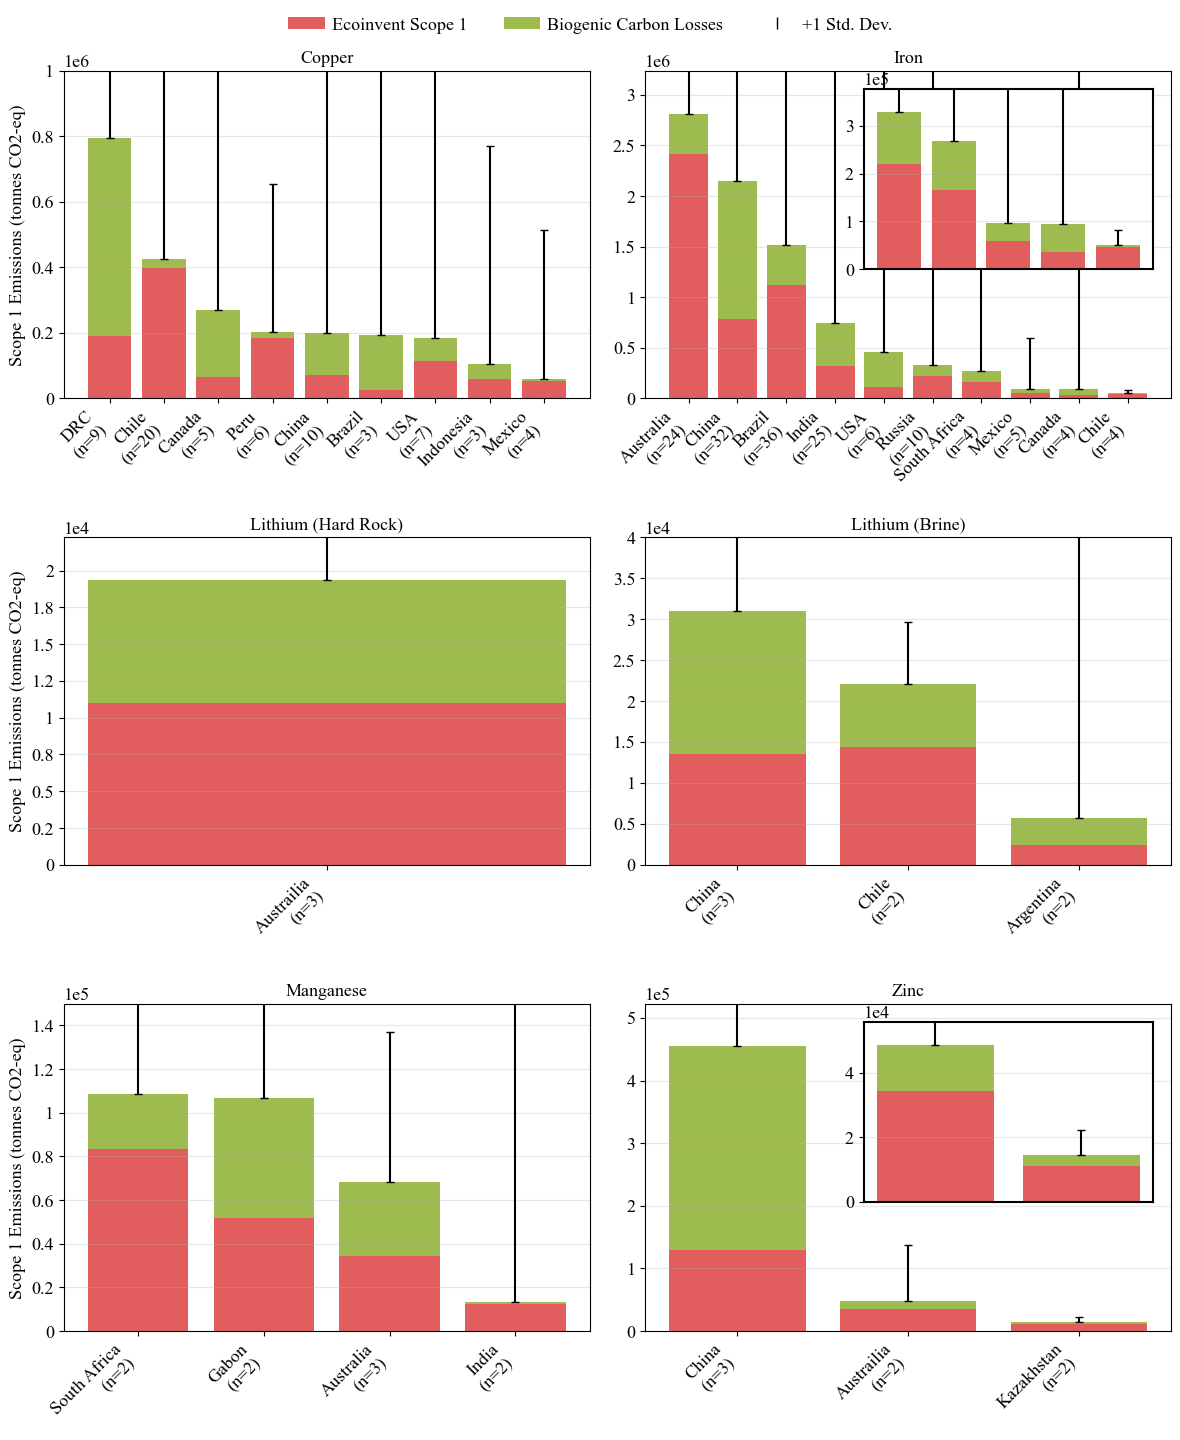

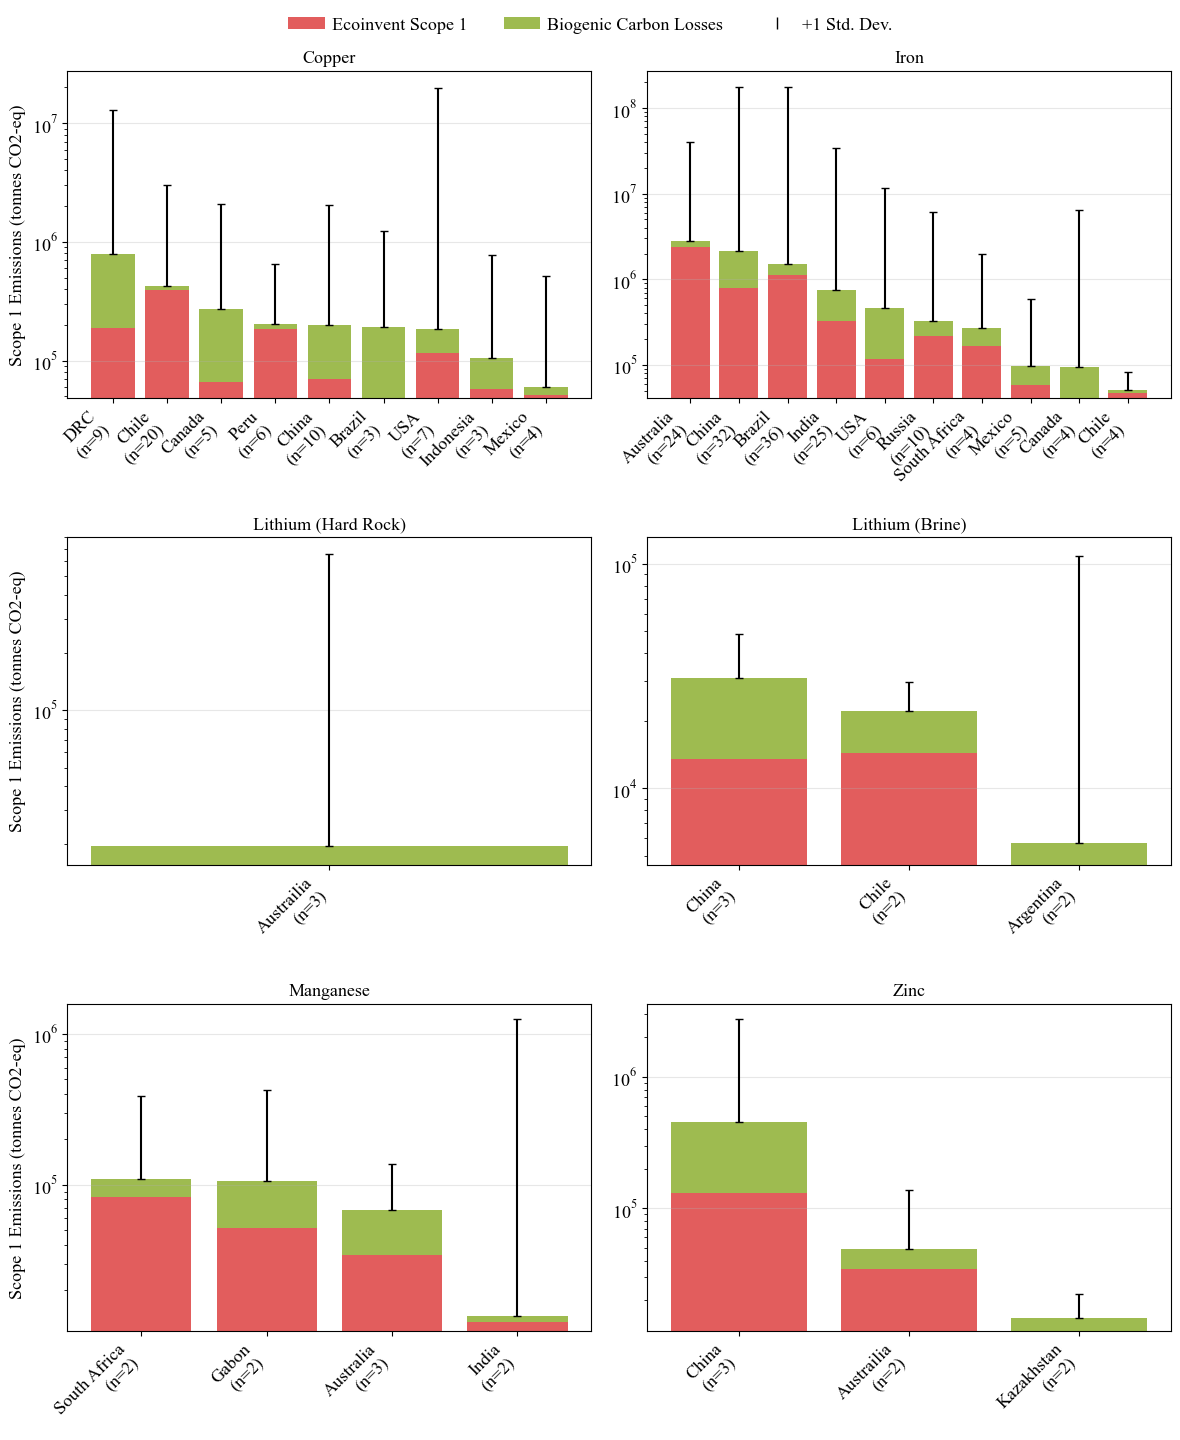

Analysis complete for Open Pit and Brine! Charts saved to 'Visualizations/Biogenic Carbon/...'

Processing Underground dataset...


C:\Users\leshe\AppData\Local\Temp\ipykernel_101908\2929662885.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.985])


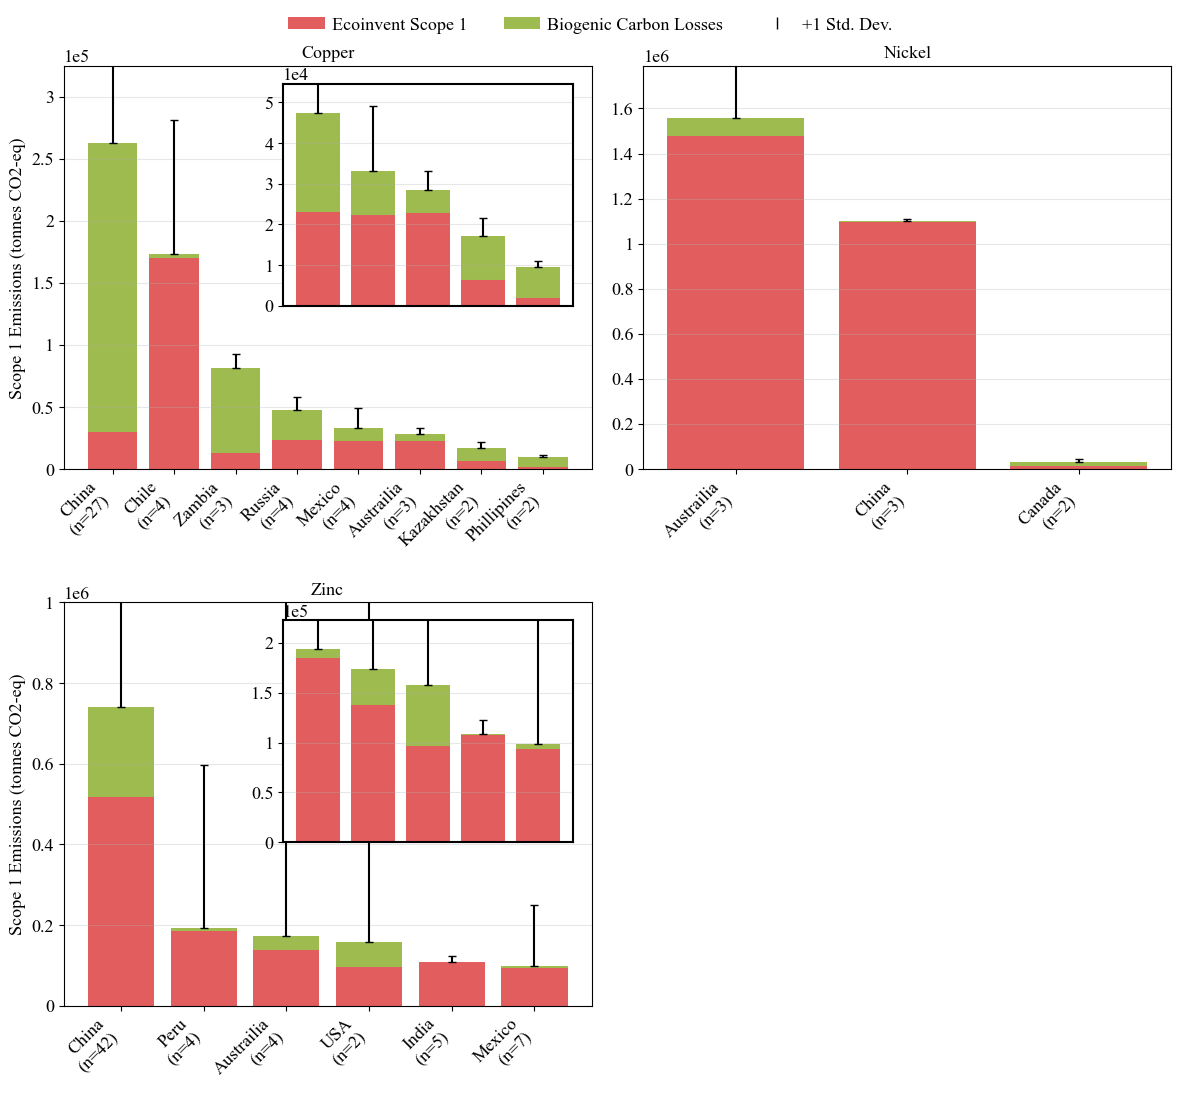

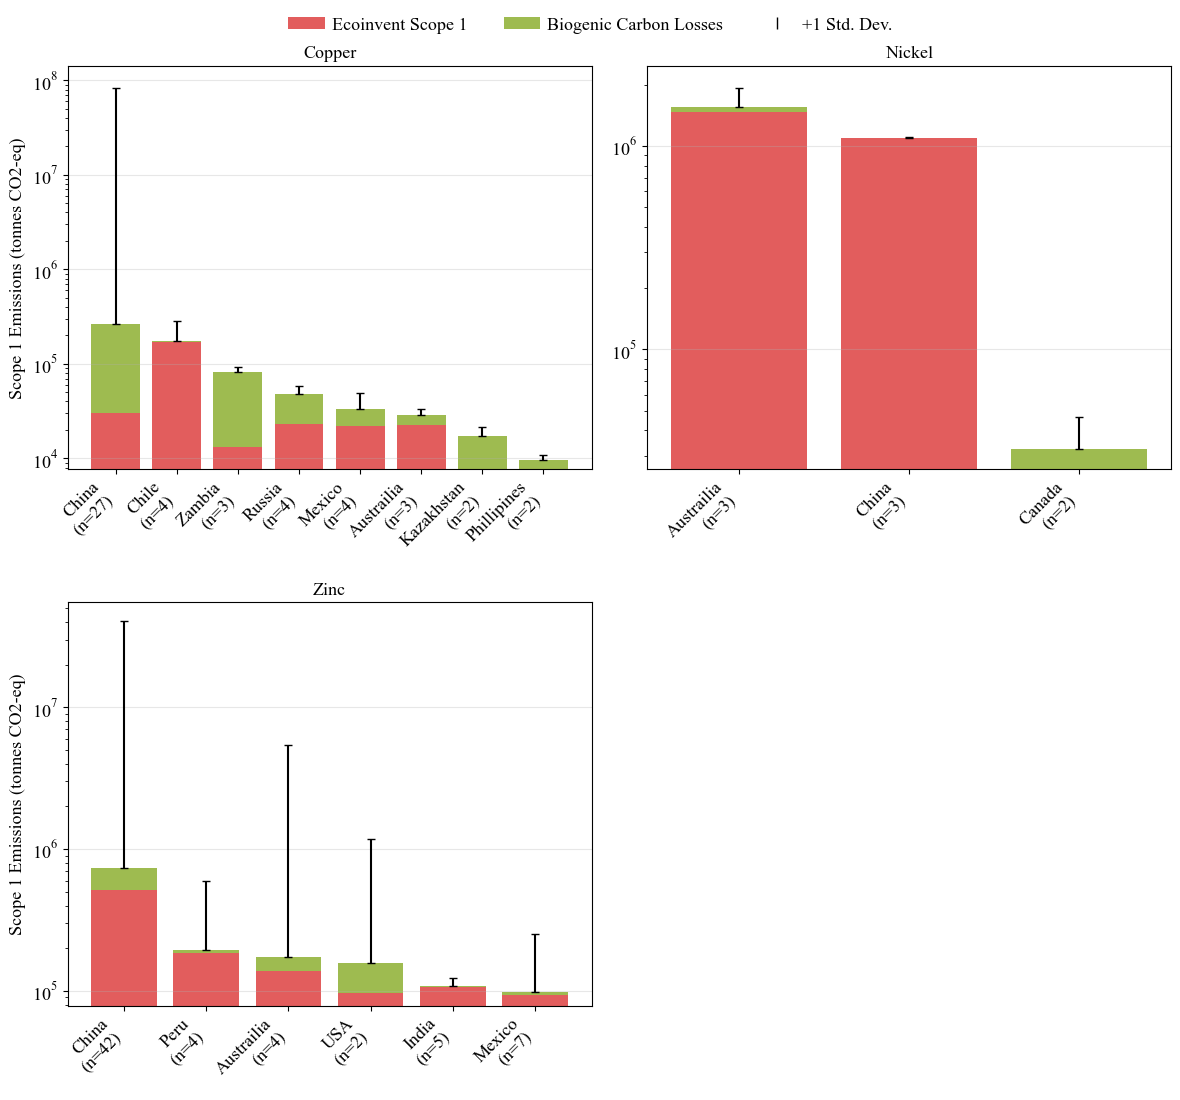

Analysis complete for Underground! Charts saved to 'Visualizations/Biogenic Carbon/...'

ANALYSIS SUMMARY
✓ Open Pit and Brine analysis completed successfully
✓ Underground analysis completed successfully

Charts saved to: Visualizations/Biogenic Carbon


In [38]:
#!/usr/bin/env python3
"""
Scope 1 Emissions Comparison Analysis — JUPYTER-NOTEBOOK VERSION
(Integrated with scientific offset y-axis tick formatting and prior customizations)

What's included:
- Insets (linear plots only):
  • Open Pit Copper: DRC, Canada, Brazil, Chile on main axis; inset shows the rest (no x-ticks in inset)
  • Open Pit Iron: China, Brazil, USA, Australia, India on main axis; inset shows the rest
  • Open Pit Manganese: South Africa on main axis; inset shows the rest
  • Open Pit Zinc: China on main axis; inset shows Australia and Kazakhstan (and any other non-priority countries if present)
  • Underground Copper: China first, Zambia second (both remain on main axis; not in inset)
  • Underground Zinc: China first; Australia also on main axis (not in inset)
- Open Pit figure uses a **2-column grid with 3 rows (fixed 2x3, max 6 panels)**.
- Open Pit data includes 'Zinc' sheet.
- Std dev shown as error bars and clipped at axes limits (long tails are cut off).
- Fixed y-axis tops (linear only) — UPDATED:
  • Underground Copper   → 5.0e6
  • Underground Zinc     → 4.0e6
  • Open Pit Copper      → 1.0e7
  • Lithium (Brine)      → 250000
  • Manganese            → 9.0e6
- Country tick labels on ALL subplots; NO x-axis title anywhere.
- Y-axis title appears on ALL AND ONLY the left-column subplots.
- Filters (Open Pit): Copper and Iron include only countries with Count ≥ 3.
- Uniform y-axis tick formatting everywhere:
  • Tick labels show mantissa only with ≤1 decimal (e.g., 1, 2.5, 9.5).
  • Shared scientific multiplier (e.g., ×1e7) appears once as offset text on the axis.
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import ScalarFormatter  # NEW

# =========================
# USER CONFIG (edit here)
# =========================
CONFIG = {
    "FONT_FAMILY": "Times New Roman",
    "FONT_SIZE": 13,
    "BOLD": False,
    "MAKE_LOG": True,  # also create log-scale figures (no insets / fixed tops applied to log)
    "OPEN_PIT_FILE": "Data Input/Biogenic Carbon/Scope_1_difference_open_pit.xlsx",
    "UNDERGROUND_FILE": "Data Input/Biogenic Carbon/Scope_1_difference_underground.xlsx",
    "OUTPUT_DIR": "Visualizations/Biogenic Carbon",
    # Includes Zinc for open pit
    "OPEN_PIT_SHEETS": ['Copper', 'Iron Ore', 'Lithium (Hard Rock)', 'Lithium (Brine)', 'Manganese', 'Molybdenum', 'Zinc'],
    "UNDERGROUND_SHEETS": ['Copper', 'Molybdenum', 'Nickel', 'Zinc'],
}

# =========================
# FONT / STYLE
# =========================
def apply_global_font(font_family: str, font_size: int, bold: bool):
    weight = 'bold' if bold else 'normal'
    plt.rcParams.update({
        'font.family': font_family,
        'font.size': font_size,
        'axes.titlesize': font_size,
        'axes.labelsize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'legend.fontsize': font_size,
        'font.weight': weight,
        'axes.titleweight': weight,
        'axes.labelweight': weight,
    })

# =========================
# UNIFORM Y-TICK FORMATTER (mantissa only; shared ×1eN offset)
# =========================
class OneDecimalScalarFormatter(ScalarFormatter):
    """ScalarFormatter that shows at most 1 decimal, drops .0, and uses scientific offset with e notation."""
    def __init__(self, *args, **kwargs):
        # useMathText=False → plain e-notation like 1e6
        super().__init__(*args, useMathText=False, **kwargs)

    def _set_format(self, vmin=None, vmax=None):
        # base numeric format; we'll still drop trailing .0 below
        self.format = "%.1f"

    def __call__(self, x, pos=None):
        if x == 0 or not np.isfinite(x):
            return "0"
        label = super().__call__(x, pos)
        # Drop trailing .0 (e.g., "5.0" -> "5")
        if label.endswith(".0"):
            label = label[:-2]
        return label

def apply_y_formatter(ax):
    """Apply consistent scientific formatting to an axis (mantissa on ticks, eN in offset text)."""
    formatter = OneDecimalScalarFormatter()
    # scilimits controls when scientific notation is used; (-1,1) shows offset for |exp|>=1
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-1, 1))
    ax.yaxis.get_offset_text().set_fontsize(CONFIG["FONT_SIZE"])

# =========================
# DATA LOADING / PROCESSING
# =========================

def load_excel_data(file_path):
    try:
        return pd.read_excel(file_path, sheet_name=None)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None


def process_sheet_data(df, sheet_name):
    df.columns = df.columns.str.strip()
    column_mapping = {}
    for col in df.columns:
        lo = col.lower()
        if 'country' in lo and 'ecoinvent' not in lo:
            column_mapping['Country'] = col
        elif 'quantity' in lo and 'kg' in lo:
            column_mapping['Quantity'] = col
        elif 'mean' in lo and 'calculated' in lo and 'co2' in lo:
            column_mapping['MeanCalculated'] = col
        elif 'std' in lo and 'calculated' in lo and 'co2' in lo:
            column_mapping['StdCalculated'] = col
        elif 'ecoinvent' in lo and 'scope' in lo and 'country' in lo:
            column_mapping['EcoinventScope1Country'] = col
        elif 'ecoinvent' in lo and 'scope' in lo and 'global' in lo:
            column_mapping['EcoinventScope1Global'] = col
        elif 'count' in lo:
            column_mapping['Count'] = col

    required = ['Country', 'Quantity', 'MeanCalculated', 'StdCalculated', 'Count']
    missing = [c for c in required if c not in column_mapping]
    if 'EcoinventScope1Country' not in column_mapping and 'EcoinventScope1Global' not in column_mapping:
        missing.append('EcoinventScope1 (Country or Global)')
    if missing:
        return None

    rows = []
    for _, r in df.iterrows():
        try:
            country = str(r[column_mapping['Country']]).strip()
            quantity_kg = float(r[column_mapping['Quantity']])
            mean_calc = float(r[column_mapping['MeanCalculated']])
            std_calc = float(r[column_mapping['StdCalculated']])
            count = int(r[column_mapping['Count']])

            eco = None
            if 'EcoinventScope1Country' in column_mapping:
                v = r[column_mapping['EcoinventScope1Country']]
                if pd.notna(v) and v != 0:
                    eco = float(v)
            if eco is None and 'EcoinventScope1Global' in column_mapping:
                v = r[column_mapping['EcoinventScope1Global']]
                if pd.notna(v):
                    eco = float(v)
            if eco is None or not country or quantity_kg <= 0:
                continue

            ecoinvent_total = (eco * quantity_kg) / 1_000
            calculated_total = (mean_calc * quantity_kg) / 1_000
            std_total = (std_calc * quantity_kg) / 1_000

            rows.append({
                'Country': country,
                'Quantity': quantity_kg,
                'Count': count,
                'EcoinventTotal': ecoinvent_total,
                'CalculatedTotal': calculated_total,
                'AdditionalEmissions': calculated_total,
                'StdDeviation': std_total
            })
        except (ValueError, TypeError):
            continue

    return pd.DataFrame(rows) if rows else None

# =========================
# INSET / PRIORITY HELPERS
# =========================

def _normalize_name(s: str) -> str:
    s = (s or "").strip().lower()
    return "".join(ch for ch in s if ch.isalnum())

_DRCS = {"drc", "democraticrepublicofthecongo", "congodemrep", "congokinshasa", "congodrc"}
_USAS = {"usa", "unitedstates", "unitedstatesofamerica", "us"}
_CHINAS = {"china", "peoplesrepublicofchina", "prc"}
_ZAMBIAS = {"zambia"}
_AUSTRALIAS = {"australia", "austrailia"}
_CANADAS = {"canada"}
_BRAZILS = {"brazil"}
_CHILES = {"chile"}
_INDIAS = {"india", "republicofindia"}
_SOUTHAFRICAS = {"southafrica", "republicofsouthafrica", "rsa"}
_KAZAKHSTANS = {"kazakhstan", "republicofkazakhstan", "kaz"}


def _pool_for(name: str):
    nl = name.lower()
    if nl == "drc":
        return _DRCS
    if nl in ("usa", "us"):
        return _USAS
    if nl == "china":
        return _CHINAS
    if nl == "zambia":
        return _ZAMBIAS
    if nl == "australia":
        return _AUSTRALIAS
    if nl == "canada":
        return _CANADAS
    if nl == "brazil":
        return _BRAZILS
    if nl == "chile":
        return _CHILES
    if nl == "india":
        return _INDIAS
    if nl in ("south africa", "southafrica", "rsa"):
        return _SOUTHAFRICAS
    if nl == "kazakhstan":
        return _KAZAKHSTANS
    return {_normalize_name(name)}


def _is_match(name: str, pool: set) -> bool:
    return _normalize_name(name) in pool


def reorder_with_priority(df: pd.DataFrame, priority_names: list):
    """
    Reorder rows so that priority countries appear first (in given order),
    and return (reordered_df, rest_indices) where rest_indices are those NOT in priority
    (to be used in inset).
    """
    if df.empty:
        return df.copy(), []
    pools = [_pool_for(p) for p in priority_names]
    parts, used = [], set()
    for pool in pools:
        mask = df["Country"].astype(str).apply(lambda c: _is_match(c, pool))
        part = df.loc[mask]
        parts.append(part)
        used.update(part.index.tolist())
    rest_df = df.loc[~df.index.isin(used)]
    reordered = pd.concat(parts + [rest_df], axis=0).reset_index(drop=True)
    rest_start = sum(len(x) for x in parts)
    return reordered, list(range(rest_start, len(reordered)))


def add_inset_zoom(ax, data: pd.DataFrame, rest_idx: list, font_size: int):
    """
    Add an inset bar chart for the 'rest' indices (non-priority countries).
    Styled as a larger inset; no country ticks/labels on the inset x-axis.
    """
    if not rest_idx:
        return
    rest = data.iloc[rest_idx]
    if rest.empty:
        return

    axins = inset_axes(ax, width="55%", height="55%", loc='upper right', borderpad=1.0)
    x_pos = np.arange(len(rest))
    axins.bar(x_pos, rest['EcoinventTotal'], color="#db3434", alpha=0.8)
    axins.bar(x_pos, rest['AdditionalEmissions'], bottom=rest['EcoinventTotal'], color="#86aa24", alpha=0.8)
    total_height = rest['EcoinventTotal'] + rest['AdditionalEmissions']

    # Std-dev as error bar (clipped at inset limits)
    axins.errorbar(
        x_pos, total_height,
        yerr=[np.zeros(len(rest)), rest['StdDeviation']],
        fmt='none', color='black', capsize=3, capthick=1
    )

    # Remove country ticks/labels on inset
    axins.set_xticks([])
    axins.set_xticklabels([])
    axins.tick_params(axis='x', length=0)

    axins.tick_params(axis='y', labelsize=font_size)
    axins.set_ylabel("")
    axins.grid(True, alpha=0.3, axis='y')

    finite = total_height[np.isfinite(total_height)]
    ymax = float(np.nanmax(finite)) if finite.size else 1.0
    axins.set_ylim(0, ymax * 1.15)

    for s in axins.spines.values():
        s.set_linewidth(1.5)

    # Apply uniform formatter to inset
    apply_y_formatter(axins)

# =========================
# PLOTTING
# =========================

def create_single_comparison_chart(all_data, output_dir, chart_type, use_log=False, font_size=10):
    if not all_data:
        return

    # Filters for Open Pit: Copper AND Iron must have Count ≥ 3
    if chart_type.lower().startswith("open pit"):
        if "Copper" in all_data:
            df_cu = all_data["Copper"]
            filt_cu = df_cu[df_cu["Count"] >= 3]
            if not filt_cu.empty:
                all_data["Copper"] = filt_cu
            else:
                del all_data["Copper"]
        if "Iron Ore" in all_data:
            df_fe = all_data["Iron Ore"]
            filt_fe = df_fe[df_fe["Count"] >= 3]
            if not filt_fe.empty:
                all_data["Iron Ore"] = filt_fe
            else:
                del all_data["Iron Ore"]

    if not all_data:
        return

    # Inset/priority specs — Open Pit priorities place rest in inset
    inset_specs = {
        #("open pit and brine", "copper"): ["DRC", "Chile", "Canada", "Peru", "China", "Brazil", "USA"],
        ("open pit and brine", "iron ore"): ["Australia", "China", "Brazil", "India", "USA"],
        #("open pit and brine", "manganese"): ["South Africa"],
        ("open pit and brine", "zinc"): ["China"],

        # Underground priorities (main axis keeps these; rest would go to inset if used)
        ("underground", "copper"): ["China", "Chile", "Zambia"],
        ("underground", "zinc"): ["China"],
    }

    # Fixed y-axis upper bounds (linear only)
    fixed_ymax = {
        ("underground", "copper"): 3.250e5,          # 0.5 × 1e7
        ("underground", "zinc"):   1.0e6,          # 4 × 1e6
        ("open pit and brine", "copper"): 1.0e6,
        ("open pit and brine", "lithium (brine)"): 4.0e4,
        ("open pit and brine", "manganese"): 1.5e5,
    }

    is_open_pit = chart_type.lower().startswith("open pit")

    # --- Figure & axes layout ---
    if is_open_pit:
        # FIXED 2x3 layout (max 6 panels)
        n_cols_current = 2
        n_rows = 3
        max_panels = n_cols_current * n_rows

        # Order materials deterministically and enforce max 6 panels
        items = list(all_data.items())
        if len(items) > max_panels:
            print(f"[Open Pit] {len(items)} materials provided; plotting first {max_panels} to fit 2x3 grid.")
            items = items[:max_panels]

        fig, axes = plt.subplots(n_rows, n_cols_current, figsize=(6 * n_cols_current, 4.8 * n_rows))
        axes_flat = list(axes.flatten())

        def is_left_column_axis(ax_obj):
            try:
                idx_ax = axes_flat.index(ax_obj)
            except ValueError:
                idx_ax = next((i for i, a in enumerate(axes_flat) if a is ax_obj), -1)
            return (idx_ax % n_cols_current) == 0
    else:
        # Default 2-column layout for Underground
        n_cols_current = 2
        n_materials = len(all_data)
        n_rows = (n_materials + n_cols_current - 1) // n_cols_current
        fig, axes = plt.subplots(n_rows, n_cols_current, figsize=(12, 5.5 * n_rows))
        if n_rows == 1 and n_materials > 1:
            axes = np.array(axes).reshape(1, -1)
        elif n_materials == 1:
            axes = np.array([[axes]])
        axes_flat = list(axes.flatten()) if n_materials > 1 else [axes[0][0]]

        # Build items for Underground after layout decisions
        items = list(all_data.items())

        def is_left_column_axis(ax_obj):
            try:
                idx_ax = axes_flat.index(ax_obj)
            except ValueError:
                idx_ax = next((i for i,a in enumerate(axes_flat) if a is ax_obj), -1)
            return (idx_ax % n_cols_current) == 0

    bar_handles = None

    # --- plotting loop ---
    for idx, (sheet_name, df_orig) in enumerate(items):
        ax = axes_flat[idx]
        # Apply uniform y formatter early
        apply_y_formatter(ax)

        key = (chart_type.lower(), sheet_name.lower())
        df = df_orig.copy()
        # Build inset mask first (before sorting), then sort by bar size (excluding StdDeviation)
        inset_mask = np.zeros(len(df), dtype=bool)
        if key in inset_specs:
            if key == ("open pit and brine", "zinc"):
                # Only Australia & Kazakhstan in the inset for Open Pit Zinc
                pools_for_inset = [_pool_for("Australia"), _pool_for("Kazakhstan")]
                inset_mask = df["Country"].astype(str).apply(
                    lambda c: any(_is_match(c, pool) for pool in pools_for_inset)
                ).to_numpy()
            else:
                # Default behavior for any chart with priorities (Open Pit or Underground): inset shows non-priority countries
                priority_pools = [_pool_for(p) for p in inset_specs[key]]
                is_priority = df["Country"].astype(str).apply(
                    lambda c: any(_is_match(c, pool) for pool in priority_pools)
                ).to_numpy()
                inset_mask = ~is_priority
        # Sort ALL bars by stacked bar size (Ecoinvent + Additional), EXCLUDING StdDeviation
        df["Total"] = df["EcoinventTotal"] + df["AdditionalEmissions"]
        df["Inset"] = inset_mask
        df = df.sort_values("Total", ascending=False).reset_index(drop=True)
        rest_idx = df.index[df["Inset"]].tolist()

        countries = df['Country']
        x = np.arange(len(countries))

        b1 = ax.bar(x, df['EcoinventTotal'], label='Ecoinvent Scope 1', color="#db3434", alpha=0.8)
        b2 = ax.bar(x, df['AdditionalEmissions'], bottom=df['EcoinventTotal'],
                    label='Biogenic Carbon Losses', color="#86aa24", alpha=0.8)

        if bar_handles is None:
            bar_handles = (b1, b2)

        total = df['EcoinventTotal'] + df['AdditionalEmissions']

        # Std-dev error bars (clipped at ylim)
        ax.errorbar(
            x, total,
            yerr=[np.zeros(len(df)), df['StdDeviation']],
            fmt='none', color='black', capsize=3, capthick=1
        )

        # Titles (rename Iron Ore -> Iron)
        display_title = 'Iron' if sheet_name == 'Iron Ore' else sheet_name
        ax.set_title(f'{display_title}')

        # Y-axis title only on left column
        if is_left_column_axis(ax):
            ax.set_ylabel('Scope 1 Emissions (tonnes CO2-eq)')
        else:
            ax.set_ylabel('')

        # X ticks (countries) on all; no xlabel
        ax.set_xticks(x)
        labels = [f"{countries.iloc[i]}\n(n={int(df.iloc[i]['Count'])})" for i in range(len(countries))]
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_xlabel('')

        ax.grid(True, alpha=0.3, axis='y')

        if use_log:
            pos = total[total > 0]
            ymin = max(1e-6, float(np.nanmin(pos)) * 0.8) if len(pos) else 1e-6
            ax.set_yscale('log')
            ax.set_ylim(bottom=ymin)
            # Formatter already applied
        else:
            if key in fixed_ymax:
                ax.set_ylim(0, fixed_ymax[key])  # long std-dev tails get clipped
            else:
                ymax = float(np.nanmax(total)) if np.any(np.isfinite(total)) else 1.0
                ax.set_ylim(0, ymax * 1.15)

            # Insets only on linear plots
            if rest_idx:
                add_inset_zoom(ax, df, rest_idx, font_size=font_size)

    # hide any unused axes
    for j in range(len(items), len(axes_flat)):
        axes_flat[j].set_visible(False)

    # Shared legend at the very top
    if bar_handles is not None:
        handles = [bar_handles[0][0], bar_handles[1][0]]

        labels = ['Ecoinvent Scope 1', 'Biogenic Carbon Losses']

        # >>> NEW: add error bar description
        import matplotlib.lines as mlines
        err_handle = mlines.Line2D([], [], color='black', marker='|',
                                   linestyle='none', markersize=8,
                                   label='+1 Std. Dev.')
        handles.append(err_handle)
        labels.append('+1 Std. Dev.')
        # <<<

        fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False,
                   bbox_to_anchor=(0.5, 1.0), borderaxespad=0.0,
                   handletextpad=0.4, labelspacing=0.4)

    # Tight layout with small headroom for legend
    plt.tight_layout(rect=[0, 0, 1, 0.985])

    # Save
    suffix = "_log" if use_log else ""
    out = os.path.join(output_dir, f'{chart_type.lower().replace(" ", "_")}_emissions_comparison{suffix}.png')
    plt.savefig(out, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

# =========================
# PIPELINE
# =========================

def process_dataset(file_path, chart_type, output_dir, expected_sheets, make_log=True, font_size=10):
    excel_data = load_excel_data(file_path)
    if excel_data is None:
        print(f"Could not load data from {file_path}")
        return False

    processed = {}
    for sheet in expected_sheets:
        if sheet in excel_data:
            df = process_sheet_data(excel_data[sheet], sheet)
            if df is not None and not df.empty:
                processed[sheet] = df

    if processed:
        create_single_comparison_chart(processed.copy(), output_dir, chart_type, use_log=False, font_size=font_size)
        if make_log:
            create_single_comparison_chart(processed.copy(), output_dir, chart_type, use_log=True, font_size=font_size)
        print(f"Analysis complete for {chart_type}! Charts saved to '{output_dir}/...'")
        return True
    else:
        print(f"No valid data found to plot for {chart_type}.")
        return False

# =========================
# RUN ANALYSIS
# =========================

def run_analysis(config: dict = CONFIG):
    apply_global_font(config["FONT_FAMILY"], config["FONT_SIZE"], config["BOLD"])
    out_dir = config["OUTPUT_DIR"]
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    print("Processing Open Pit and Brine dataset...")
    s1 = process_dataset(
        config["OPEN_PIT_FILE"], "Open Pit and Brine", out_dir,
        config["OPEN_PIT_SHEETS"], make_log=config["MAKE_LOG"], font_size=config["FONT_SIZE"]
    )

    print("\nProcessing Underground dataset...")
    s2 = process_dataset(
        config["UNDERGROUND_FILE"], "Underground", out_dir,
        config["UNDERGROUND_SHEETS"], make_log=config["MAKE_LOG"], font_size=config["FONT_SIZE"]
    )

    print("\n" + "=" * 50)
    print("ANALYSIS SUMMARY")
    print("=" * 50)
    print("✓ Open Pit and Brine analysis completed successfully" if s1 else "✗ Open Pit and Brine analysis failed")
    print("✓ Underground analysis completed successfully" if s2 else "✗ Underground analysis failed")
    if s1 or s2:
        print(f"\nCharts saved to: {out_dir}")
    else:
        print("\nNo charts were generated.")

# Auto-run
run_analysis(CONFIG)

